In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler


c:\Users\intern2\.conda\envs\machineLearnng\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
asset_pchange_list = []
asset_price_list = []


df = pd.read_excel('PCA.xlsx', sheet_name=2)
p_date_list = np.flip(df.iloc[:,0].to_numpy().astype('datetime64[D]'))
num_of_asset = len(df.columns)
for i in range(1, num_of_asset):
    asset_array = df.iloc[:,i].to_numpy()
    mask = ~np.isnan(asset_array)
    asset_array_no_na = asset_array[mask]
    asset_pchange_list.append(np.flip(asset_array_no_na))

df = pd.read_excel('PCA.xlsx', sheet_name=1)
date_list = np.flip(df.iloc[:,0].to_numpy().astype('datetime64[D]'))
num_of_asset = len(df.columns)
for i in range(1, num_of_asset):
    asset_array = df.iloc[:,i].to_numpy()
    mask = ~np.isnan(asset_array)
    asset_array_no_na = asset_array[mask]
    asset_price_list.append(np.flip(asset_array_no_na))

In [24]:
training_asset_pchange_list = np.array(asset_pchange_list)[:, :960]
testing_asset_pchange_list = np.array(asset_pchange_list)[:, 960:]

training_p_date_list = np.array(p_date_list)[:960]
testing_p_date_list = np.array(p_date_list)[960:]

training_asset_price_list = np.array(asset_price_list)[:,:960]
testing_asset_price_list = np.array(asset_price_list)[:,960:]

training_date_list = np.array(date_list)[:960]
testing_date_list = np.array(date_list)[960:]

In [42]:
class TSMD():
    def __init__(self, data_array):
        self.data_array = data_array
        self.e_dist_list = []
        self.n_smallest_e_dist_list = []
        self.n_smallest_index = []
        self.target_window = 0
    
    def search(self, search_target, n=3, p_change = True):
        if p_change:
            self.search_target = search_target
            target_window = len(self.search_target)
            self.target_window = target_window
            data_array = self.data_array

            e_dist_list = []
            for i in range(len(data_array) - target_window + 1):
                compare_array = data_array[i:i+target_window]
                E_dist = np.linalg.norm(np.array(compare_array) - np.array(search_target))
                e_dist_list.append(E_dist)
            self.e_dist_list = e_dist_list
            n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]

            self.n_smallest_e_dist_list = n_smallest_e_dist_list

            n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
            self.n_smallest_index = n_smallest_index
        else:
            self.search_target = search_target
            target_window = len(self.search_target)
            self.target_window = target_window
            data_array = self.data_array

            e_dist_list = []
            for i in range(len(data_array) - target_window + 1):
                compare_array = TimeSeriesScalerMeanVariance().fit_transform([data_array[i:i+target_window]])[0]
                E_dist = np.linalg.norm(np.array(compare_array) - TimeSeriesScalerMeanVariance().fit_transform([search_target])[0])
                e_dist_list.append(E_dist)
            self.e_dist_list = e_dist_list
            n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]

            self.n_smallest_e_dist_list = n_smallest_e_dist_list

            n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
            self.n_smallest_index = n_smallest_index

def plot(index_data_arr, index_date_arr, p_data_arr, p_date_arr, n_smallest_index, target_window, target_index):
    # plt.figure(figsize=(26, 9))
    # plt.plot(p_date_arr[:len(p_data_arr)], p_data_arr)
    # for index in n_smallest_index:
    #     plt.plot(p_date_arr[index:index+target_window], p_data_arr[index:index+target_window], 'r-')
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.title('Time Series Data')
    # plt.show()

    plt.figure(figsize=(26, 9))
    plt.plot(index_date_arr[:len(index_data_arr)], index_data_arr)
    for index in n_smallest_index:
        plt.plot(index_date_arr[index:index+target_window], index_data_arr[index:index+target_window], 'r-')
    plt.plot(index_date_arr[target_index:target_index+target_window], index_data_arr[target_index:target_index+target_window], 'g-')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Data')
    plt.show()

In [43]:
start_index = 90
window = 16
n = 15
per = True

if per:


    tsdm_result = []
    for i in range(len(training_asset_pchange_list)):
        tsmd = TSMD(training_asset_pchange_list[i])
        tsmd.search(testing_asset_pchange_list[i][start_index:start_index+window], n)
        tsdm_result.append(tsmd.e_dist_list)
    e_dist_list = reduce(np.add, tsdm_result)
    n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]
    n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
    # Print the result
    print(n_smallest_index)

else:
    tsdm_result = []
    for i in range(len(training_asset_price_list)):
        tsmd = TSMD(training_asset_price_list[i])
        tsmd.search(testing_asset_price_list[i][start_index:start_index+window], n, False)
        tsdm_result.append(tsmd.e_dist_list)
    e_dist_list = reduce(np.add, tsdm_result)
    n_smallest_e_dist_list = np.partition(e_dist_list, n)[:n]
    n_smallest_index = np.where(np.isin(e_dist_list, n_smallest_e_dist_list))[0]
    # Print the result
    print(n_smallest_index)

[158 318 337 340 362 366 369 372 523 647 707 805 844 855 940]


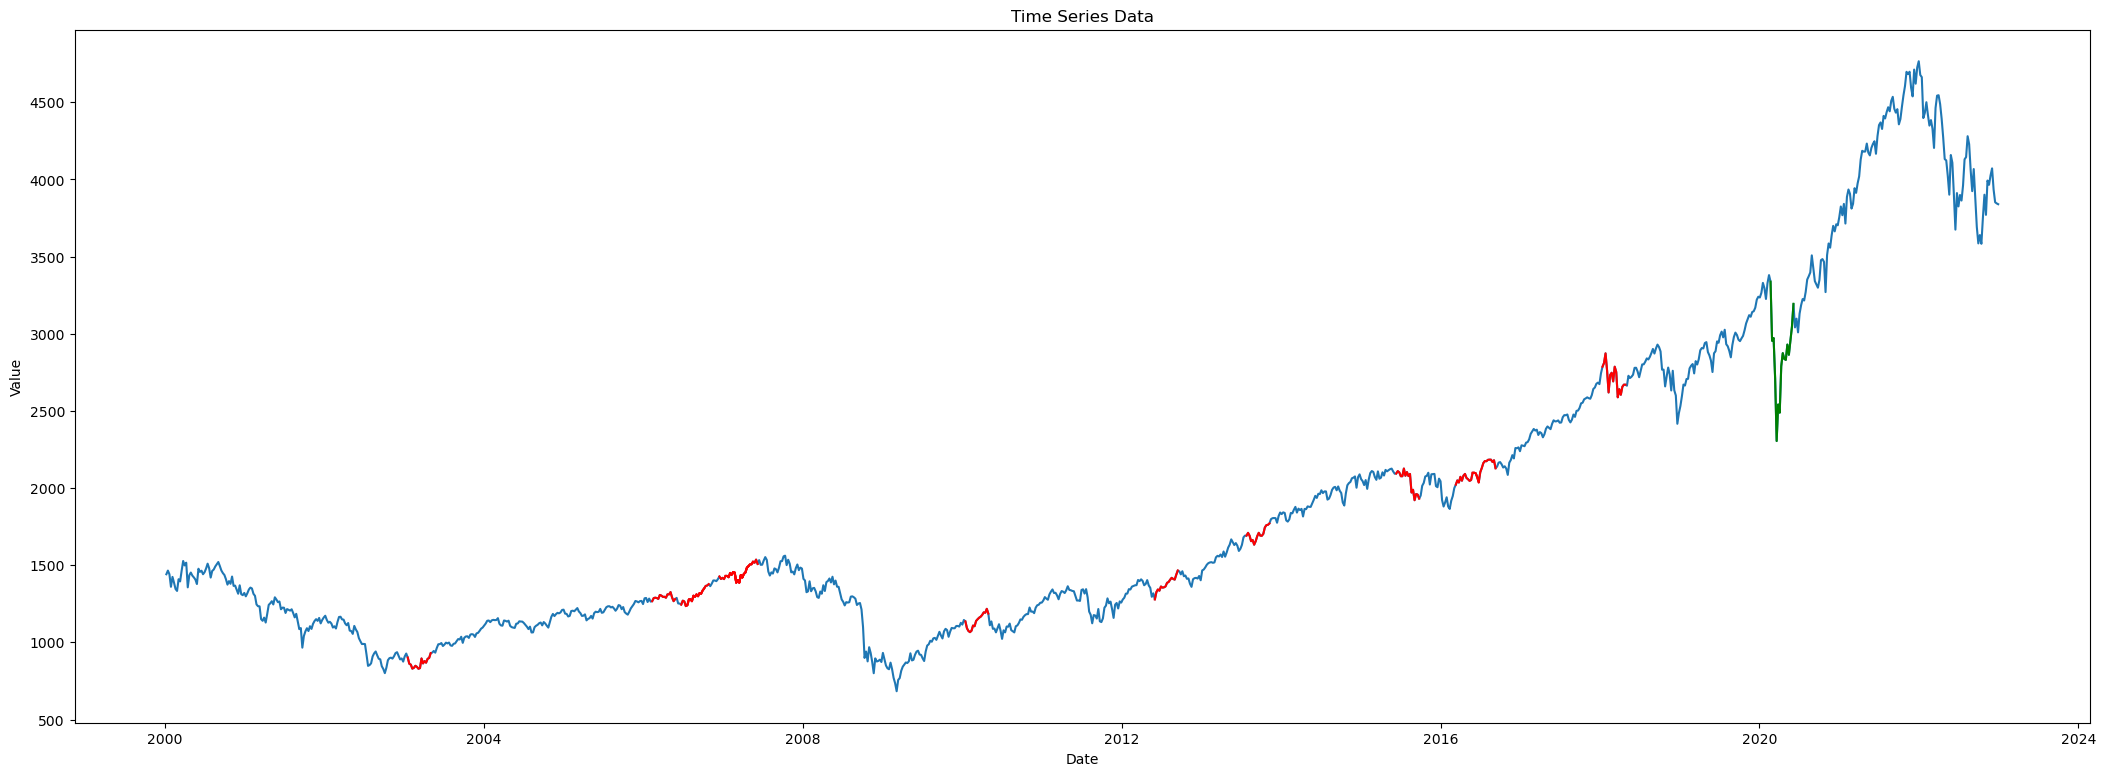

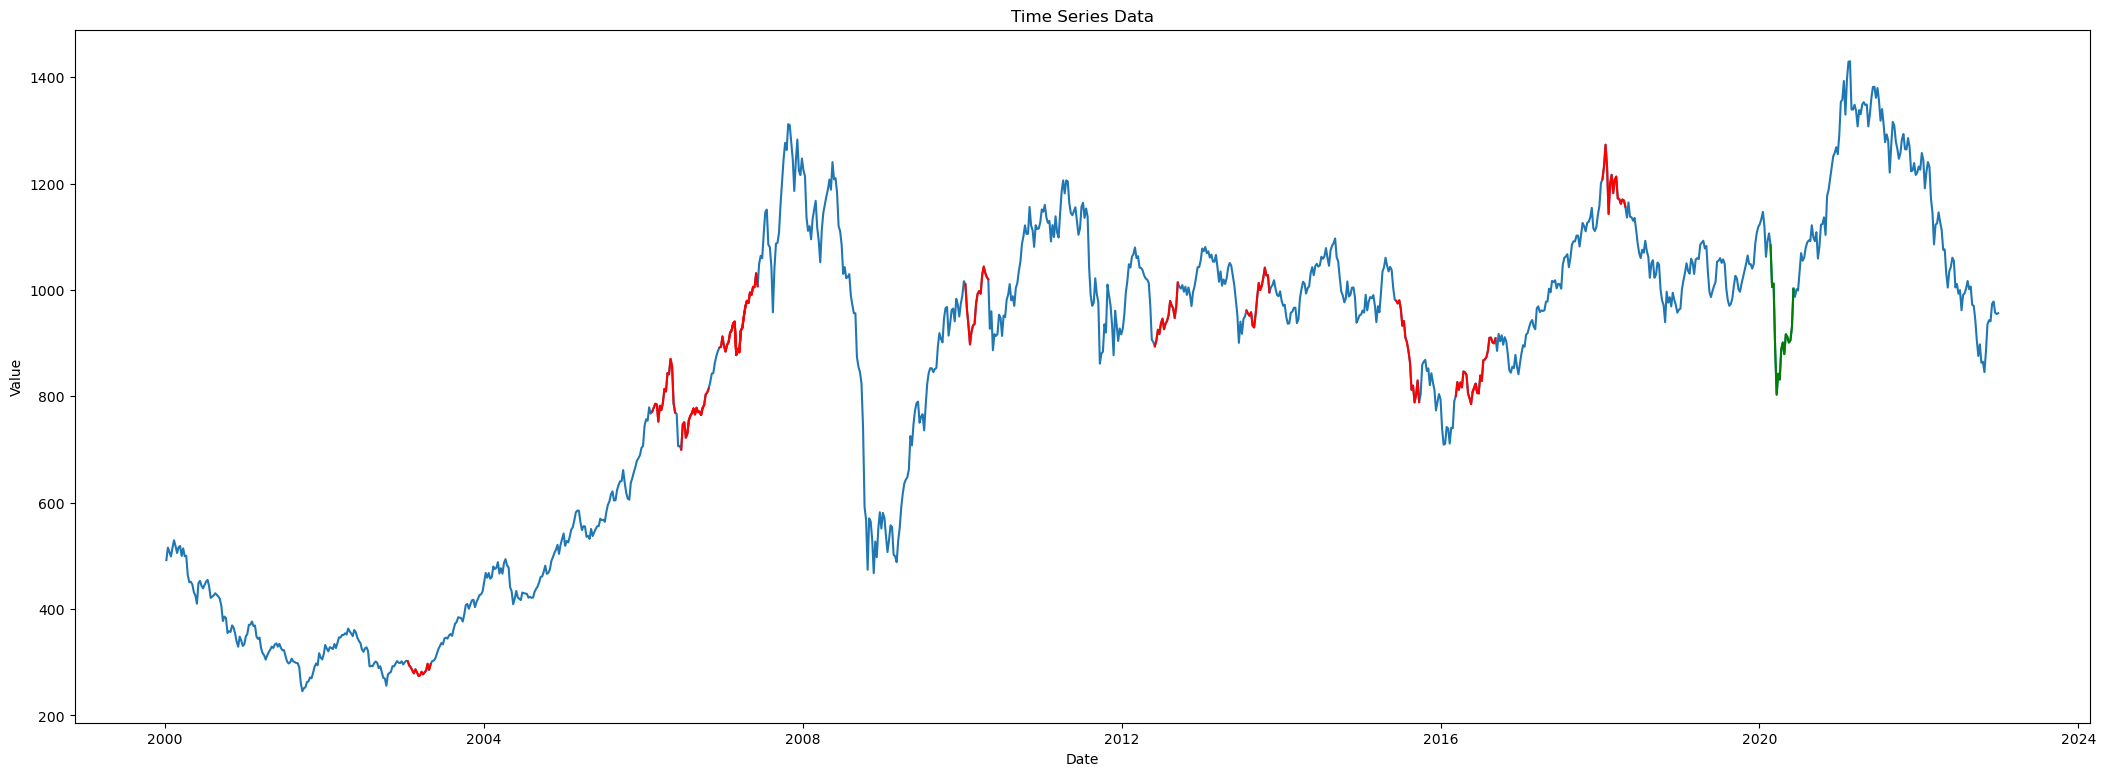

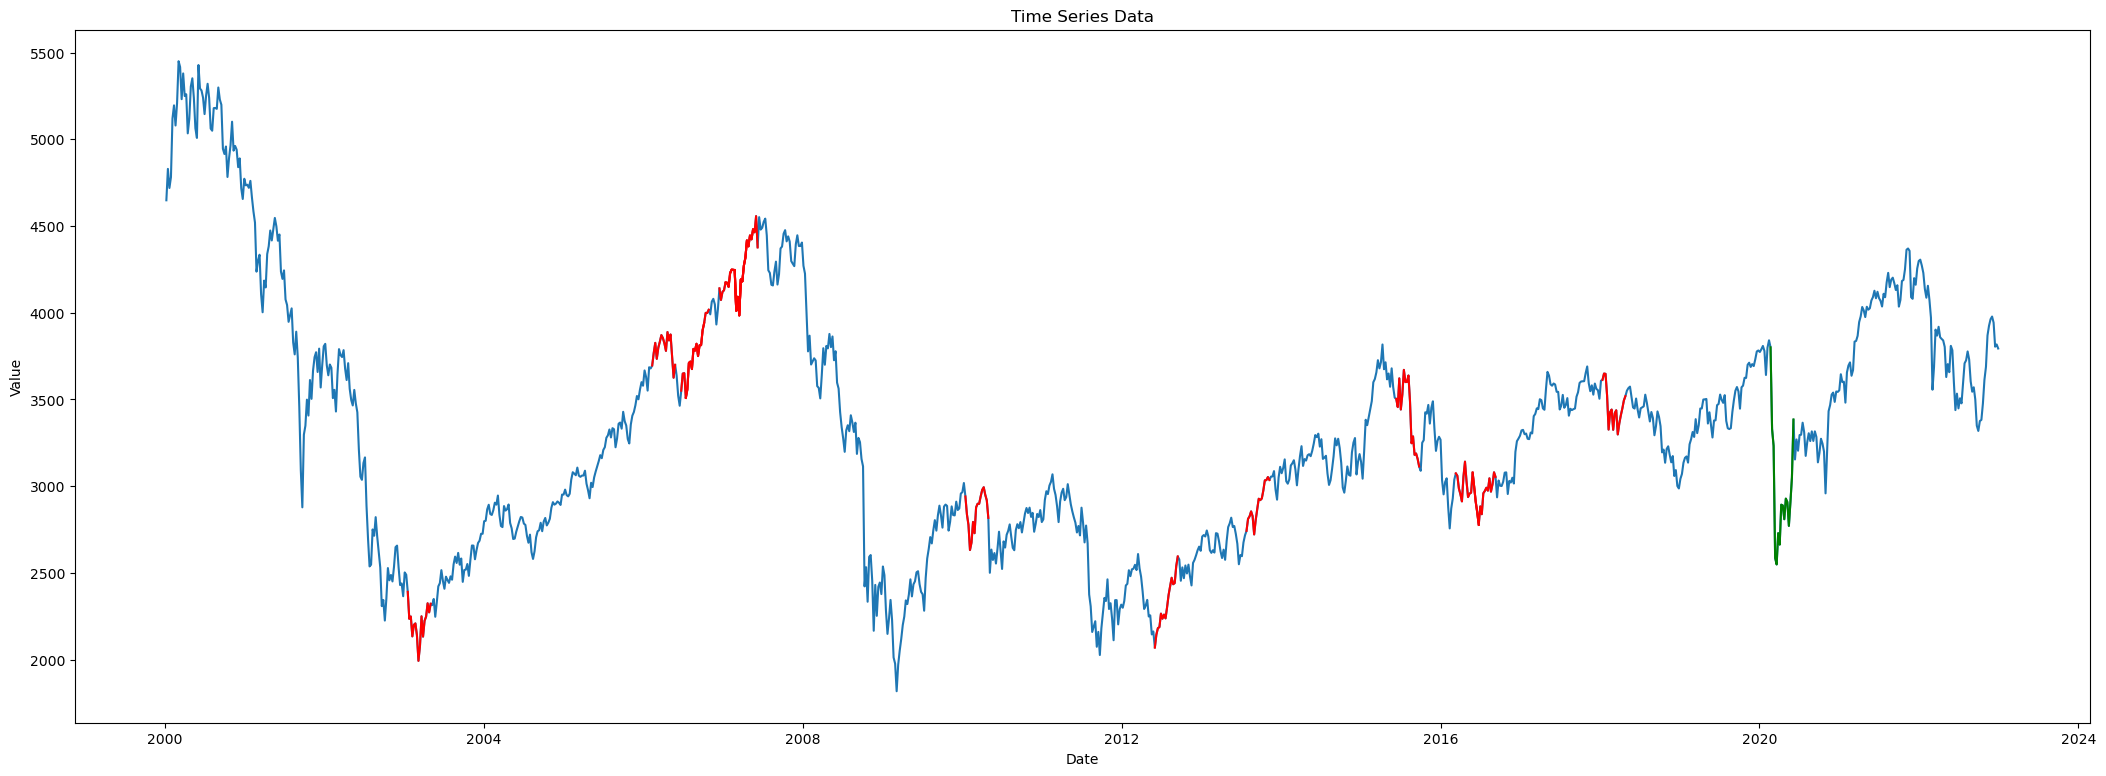

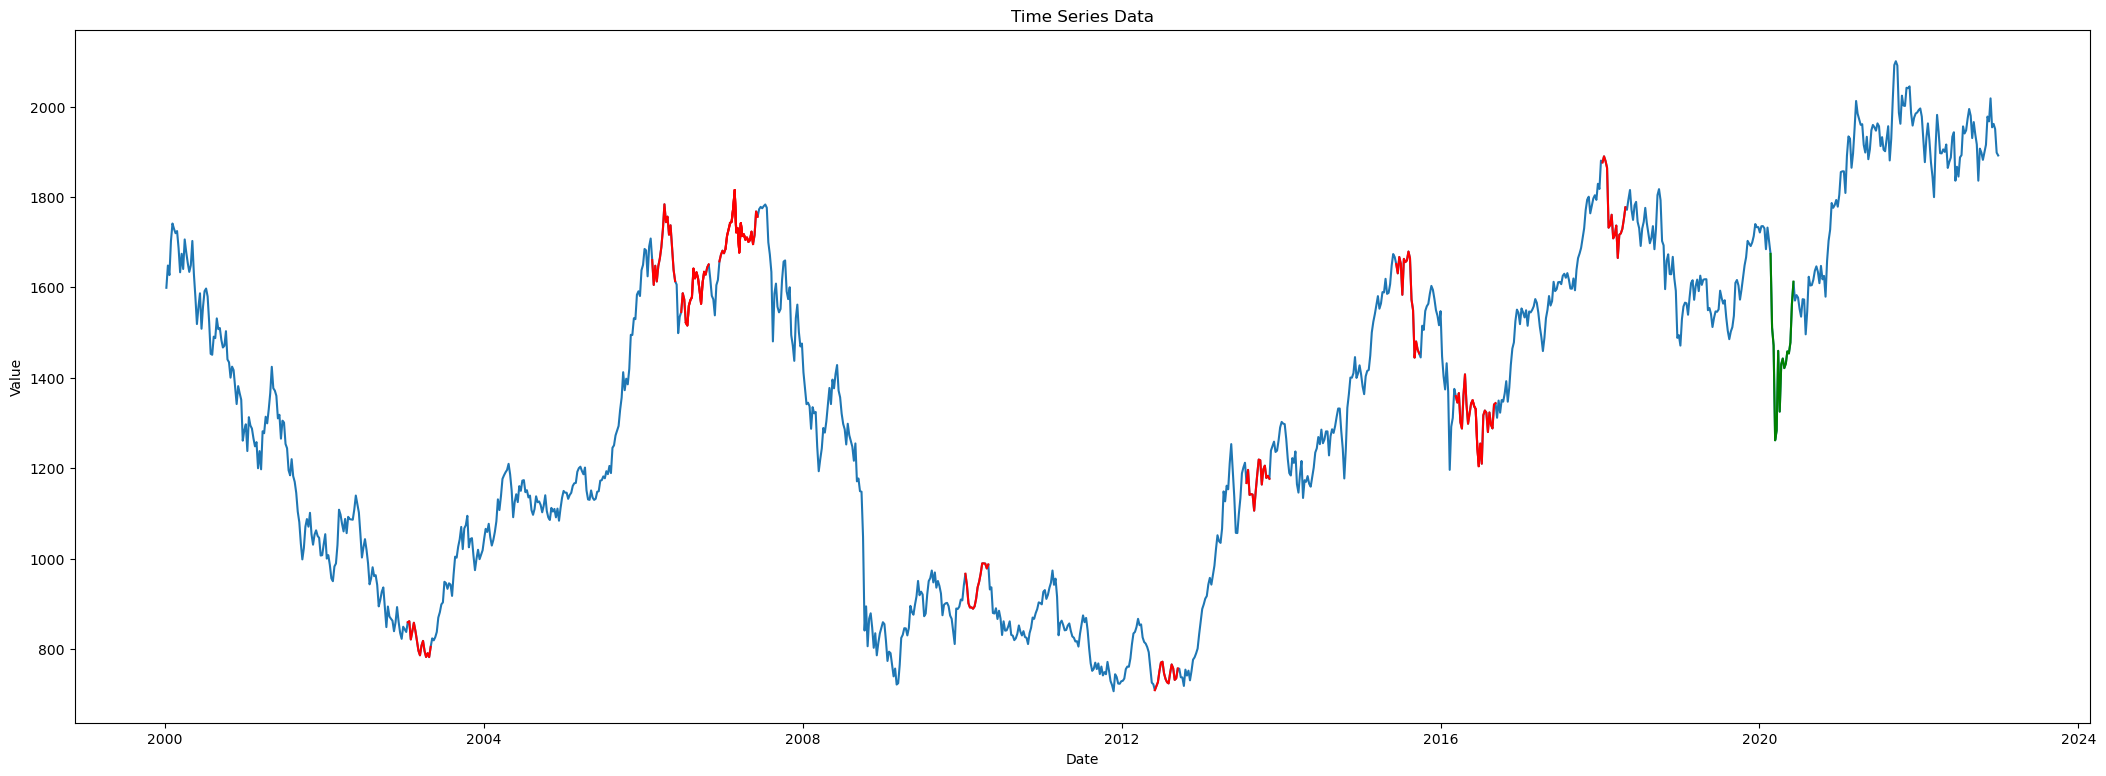

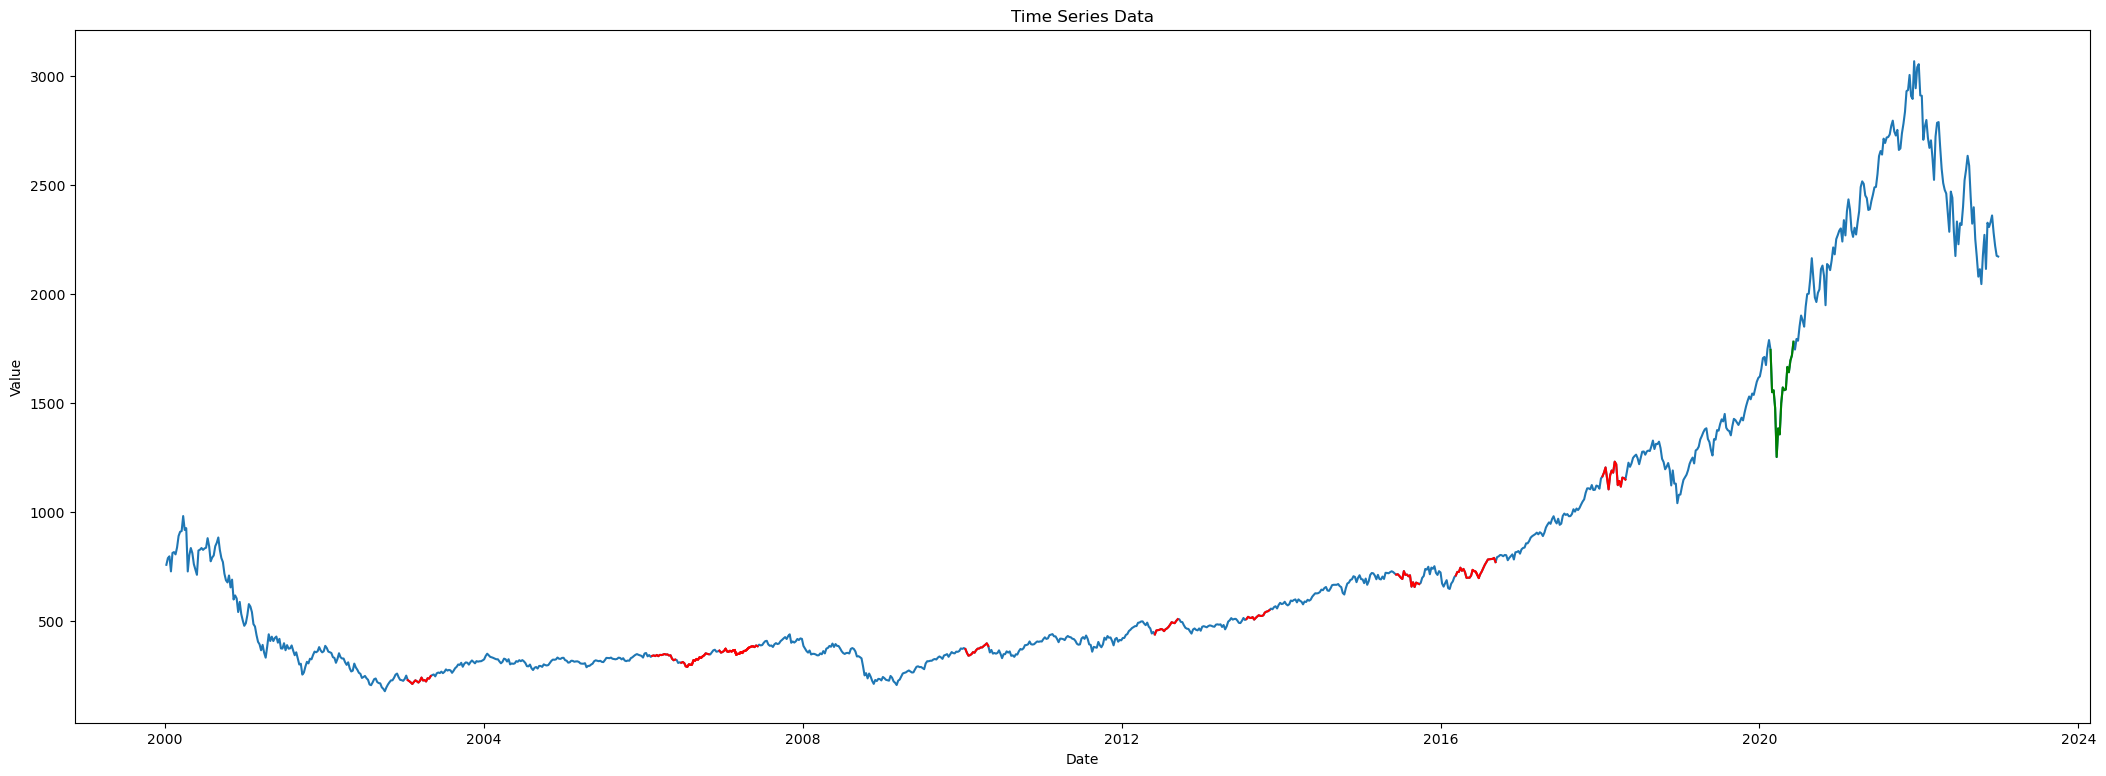

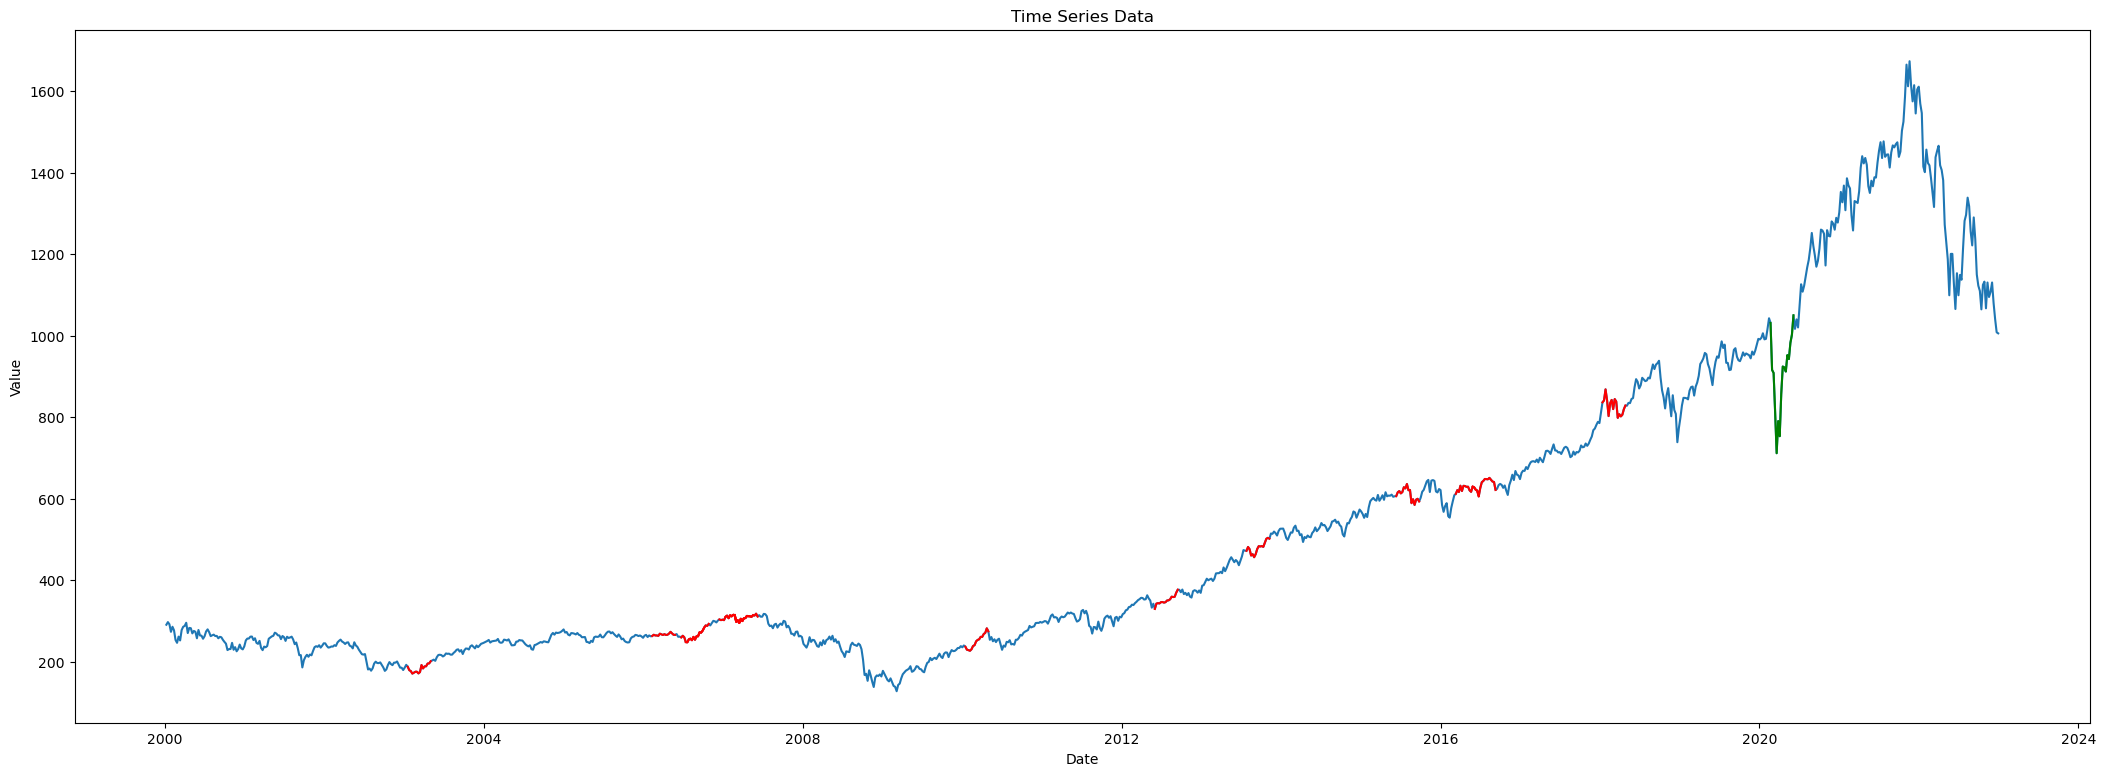

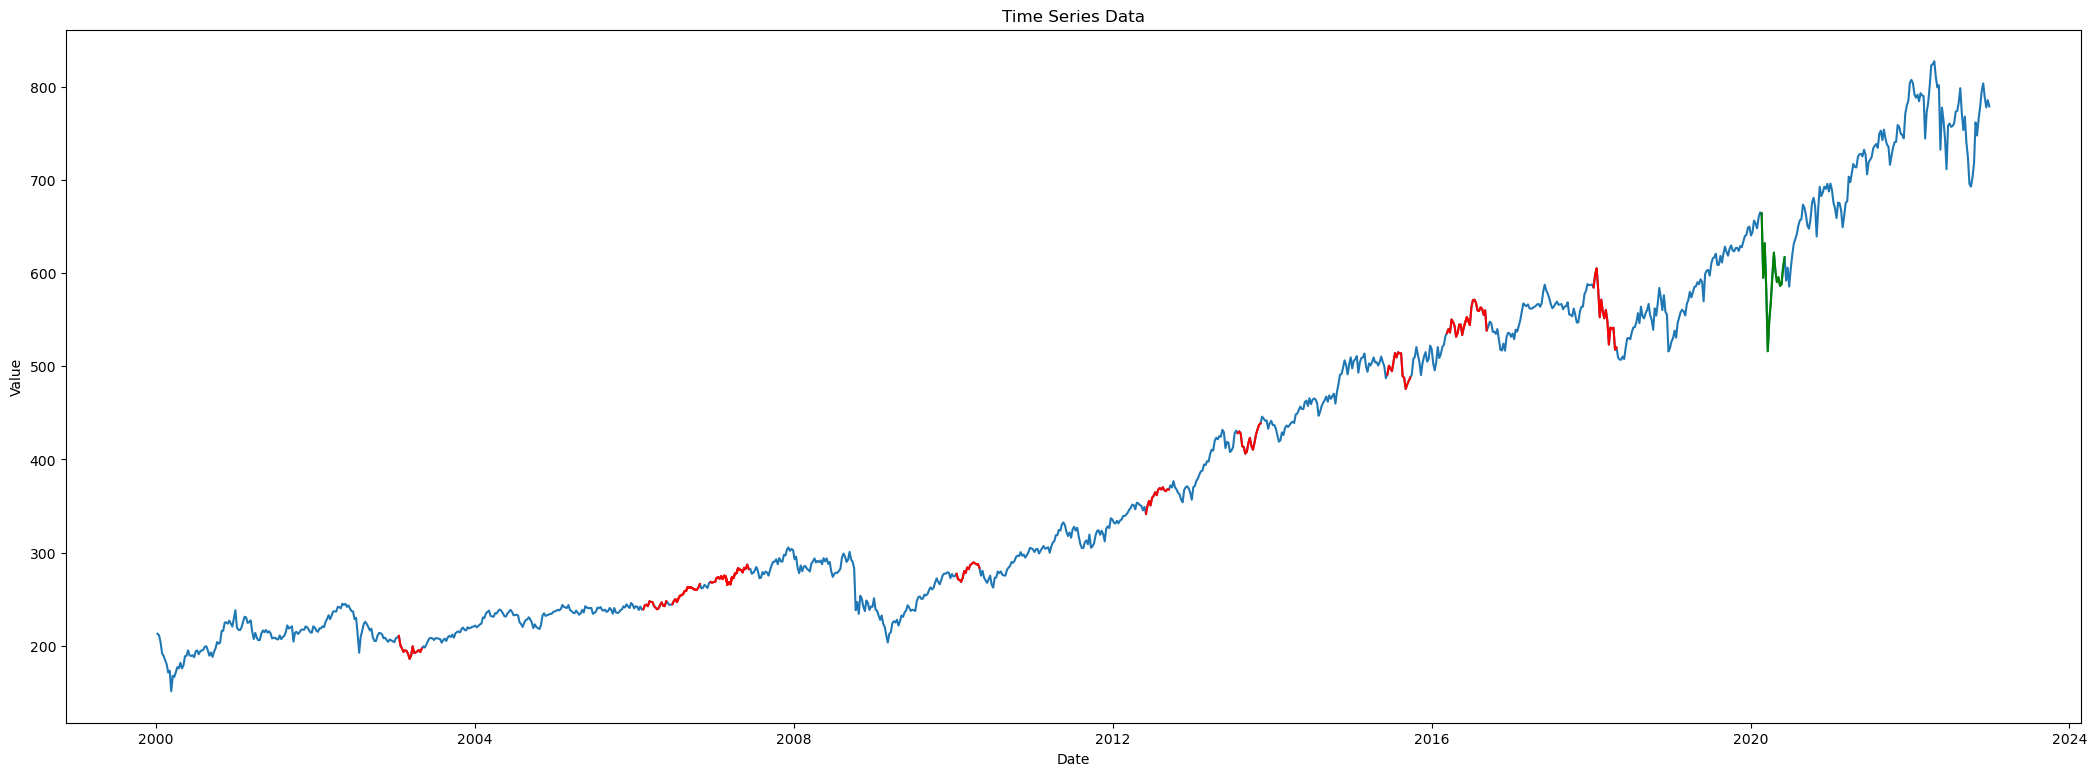

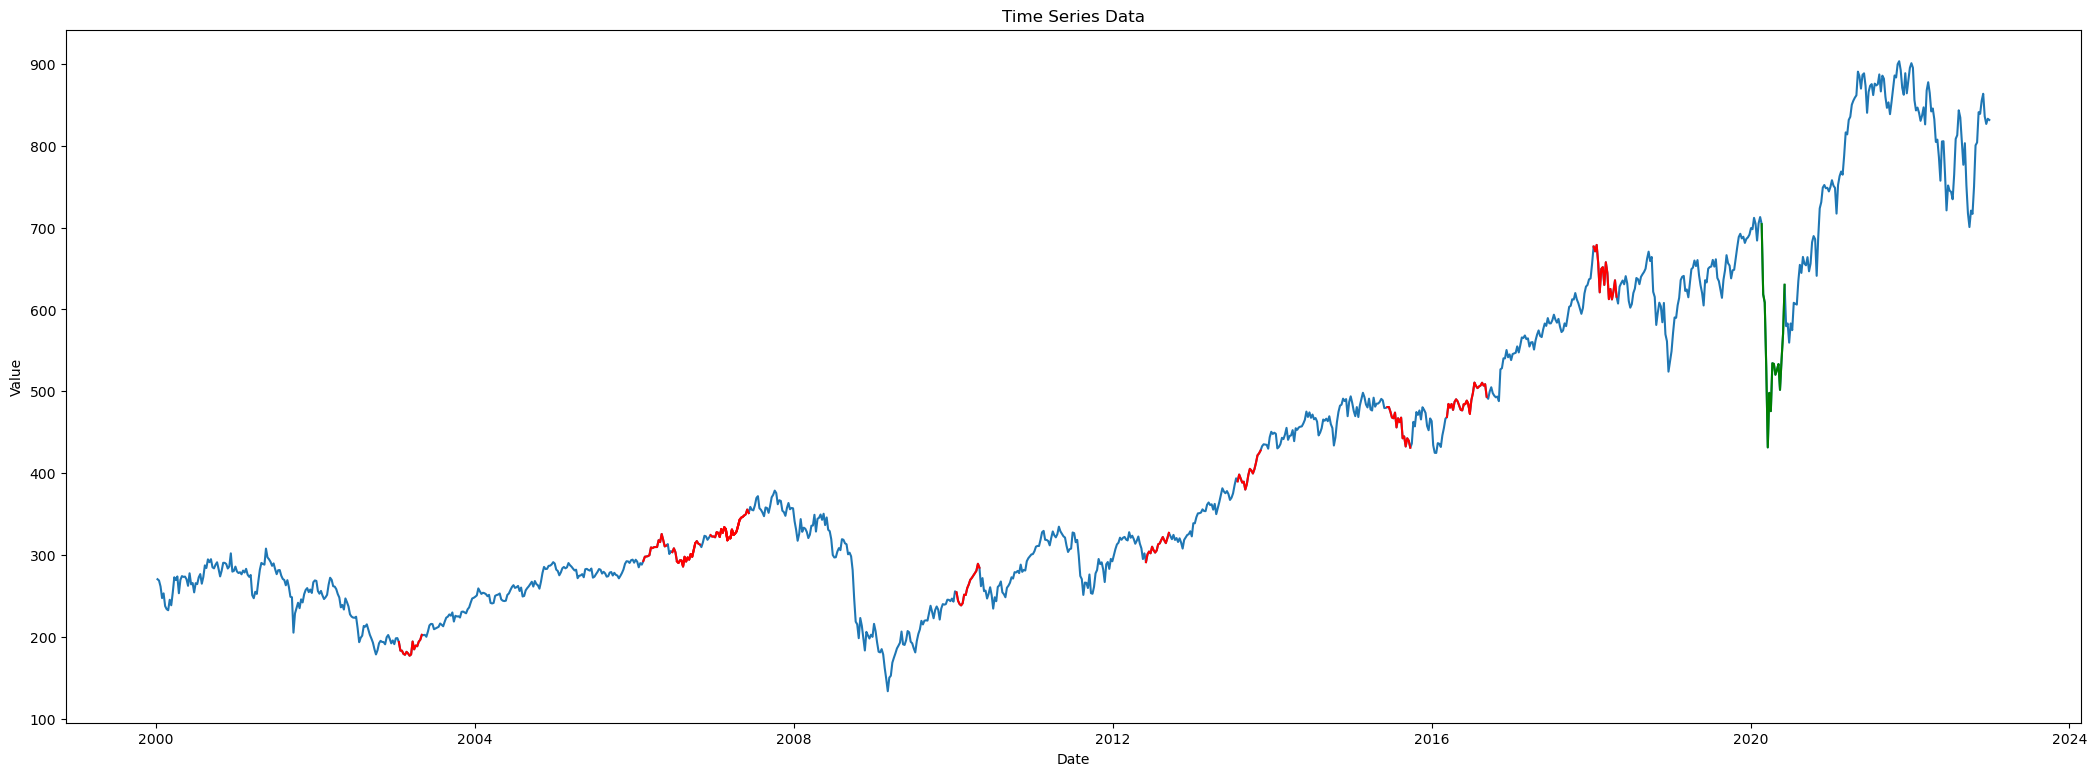

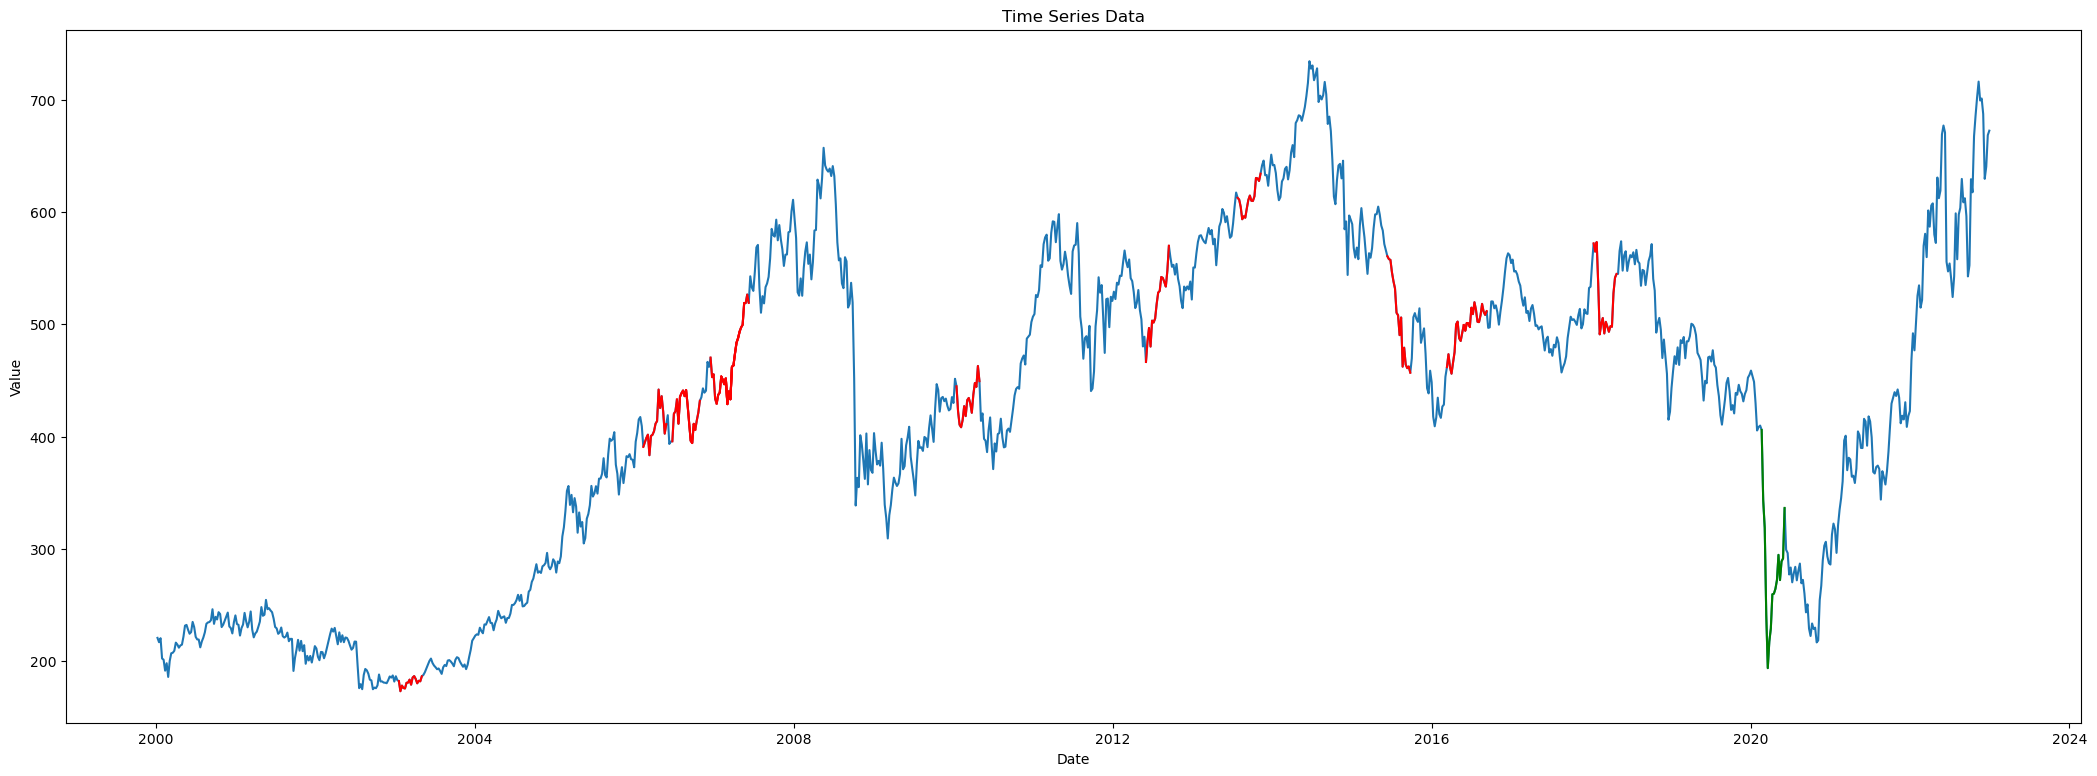

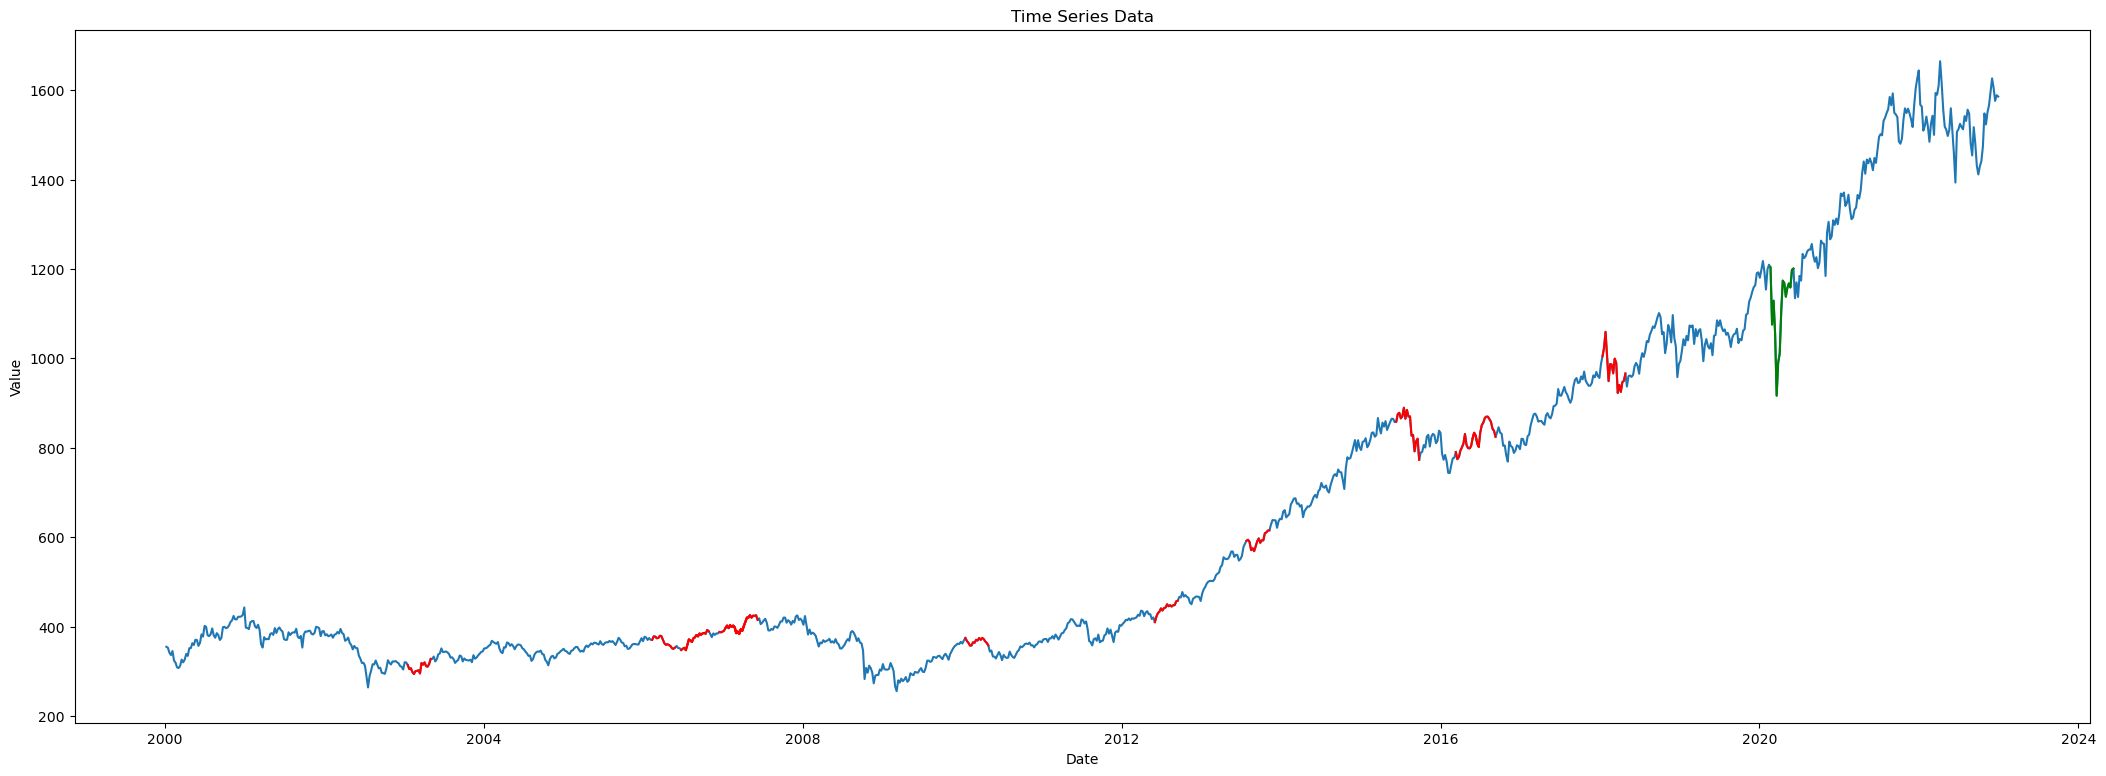

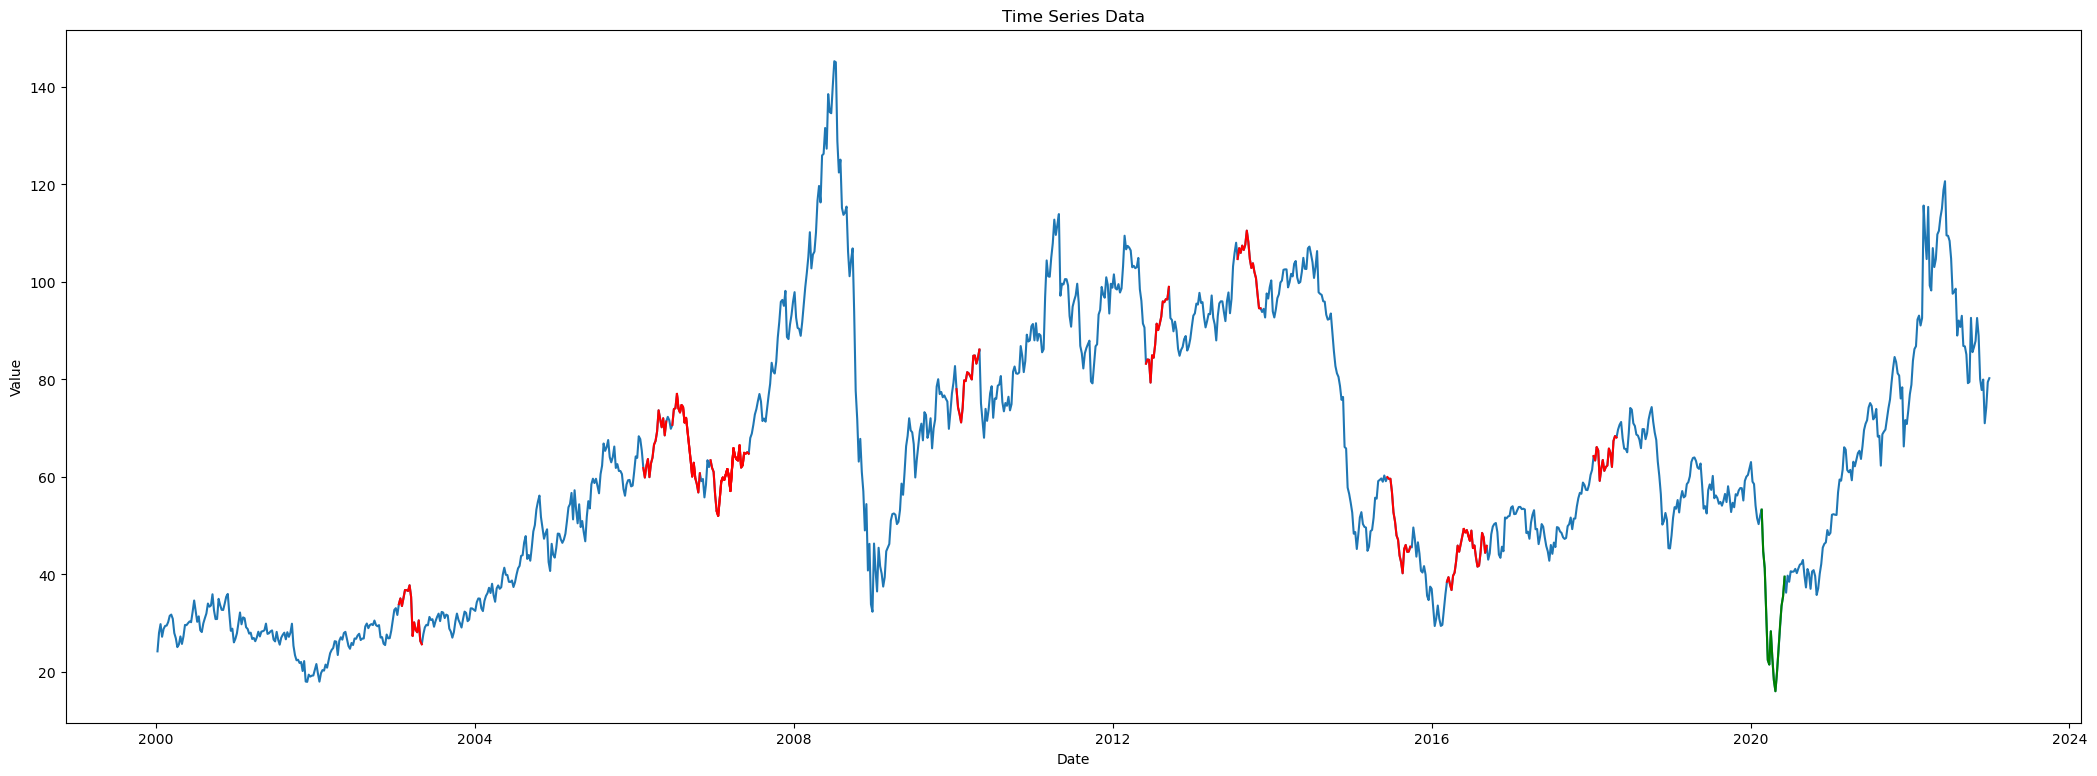

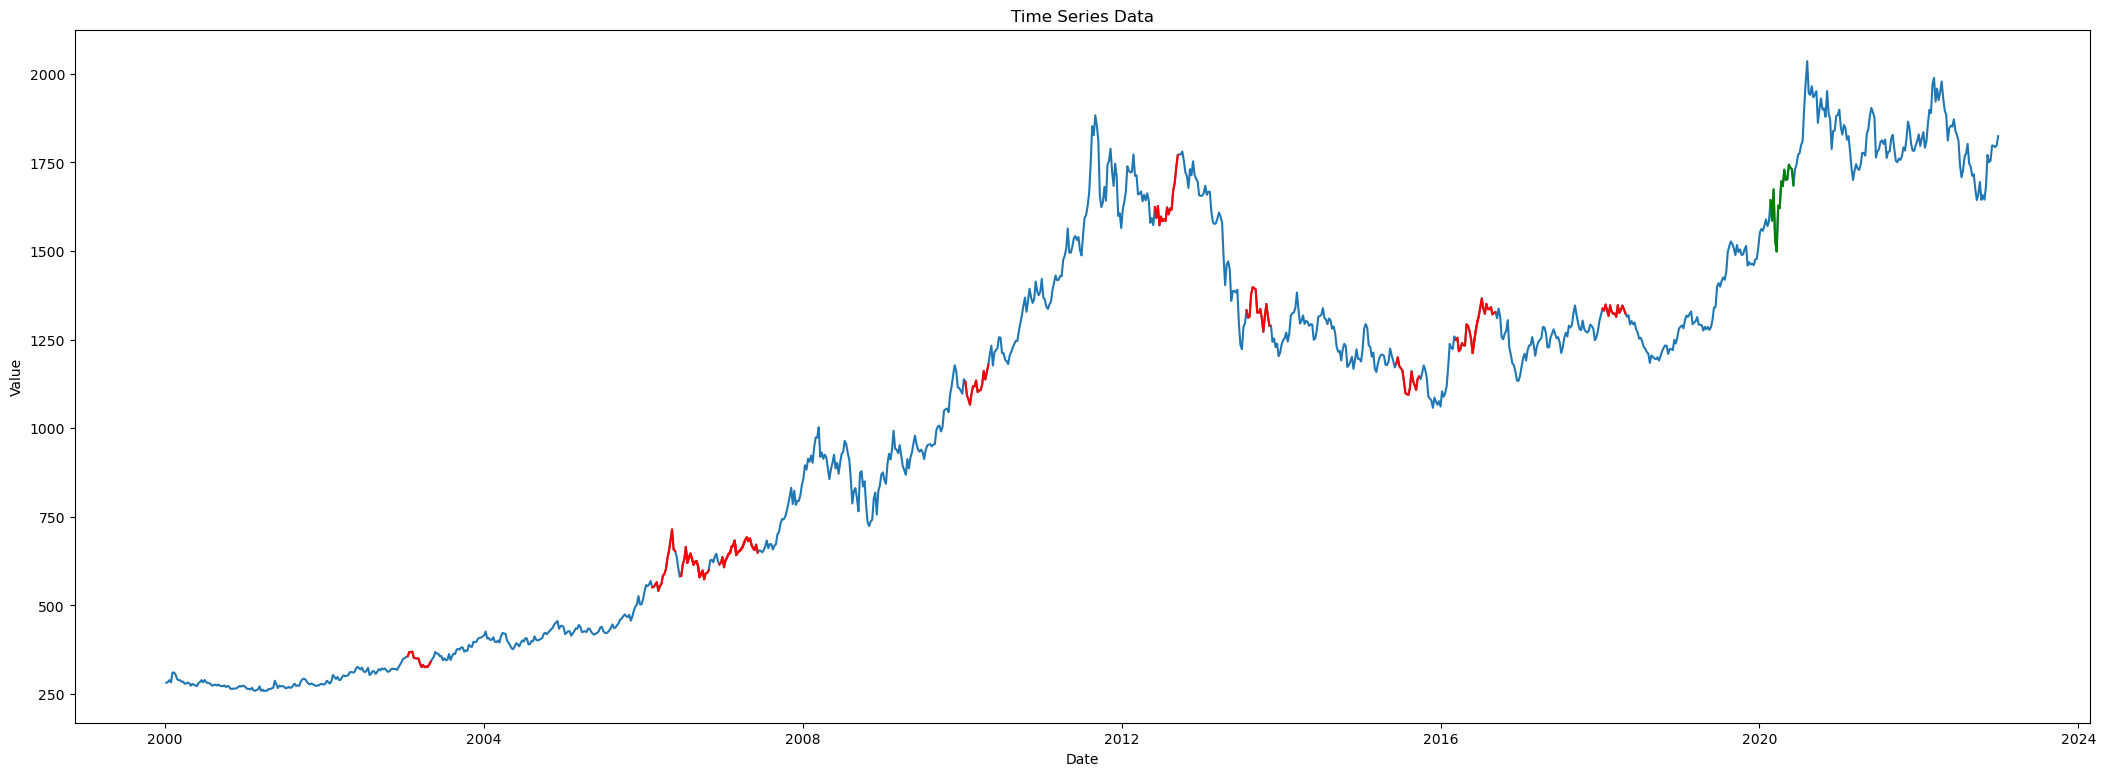

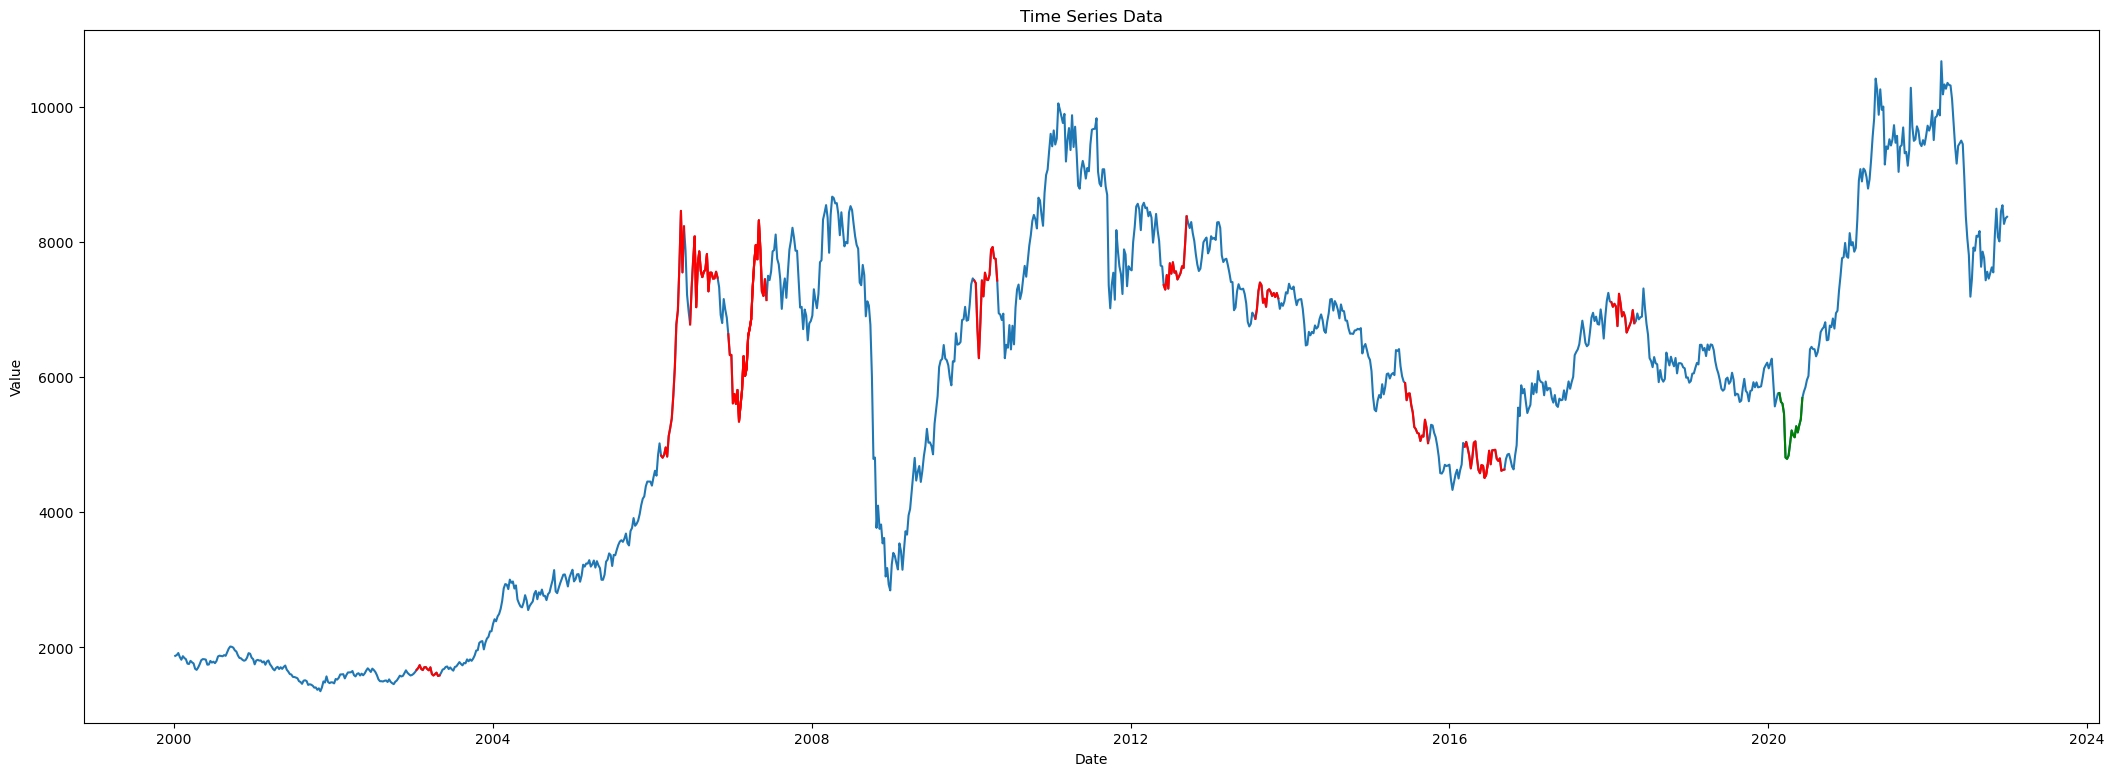

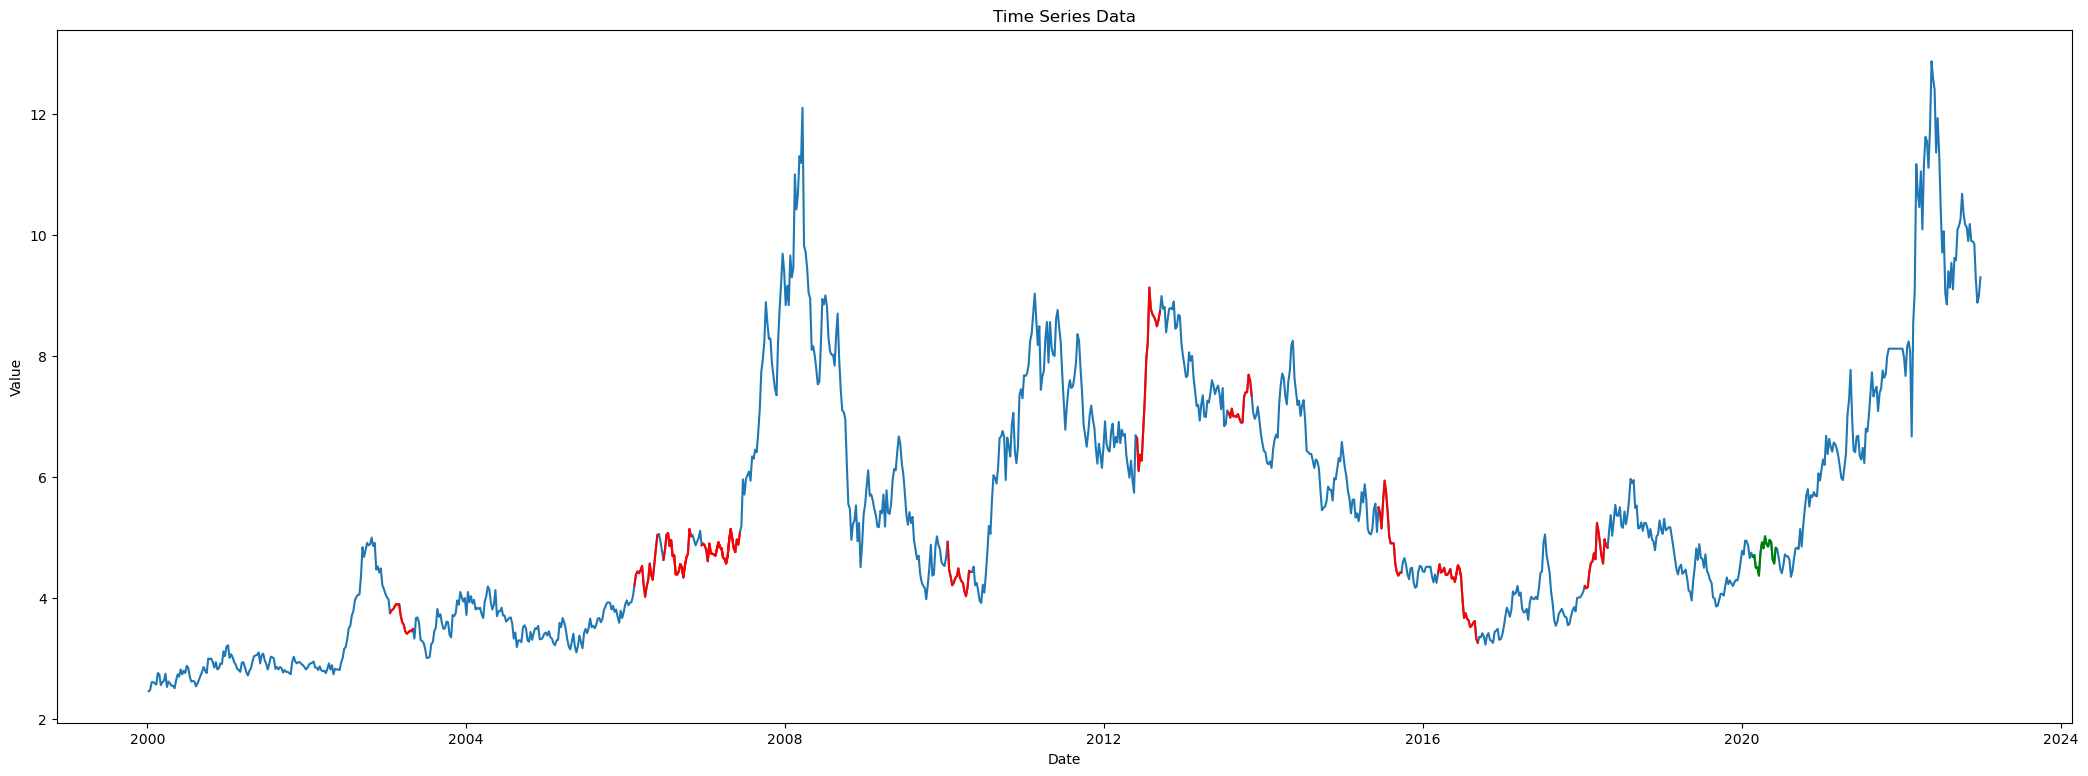

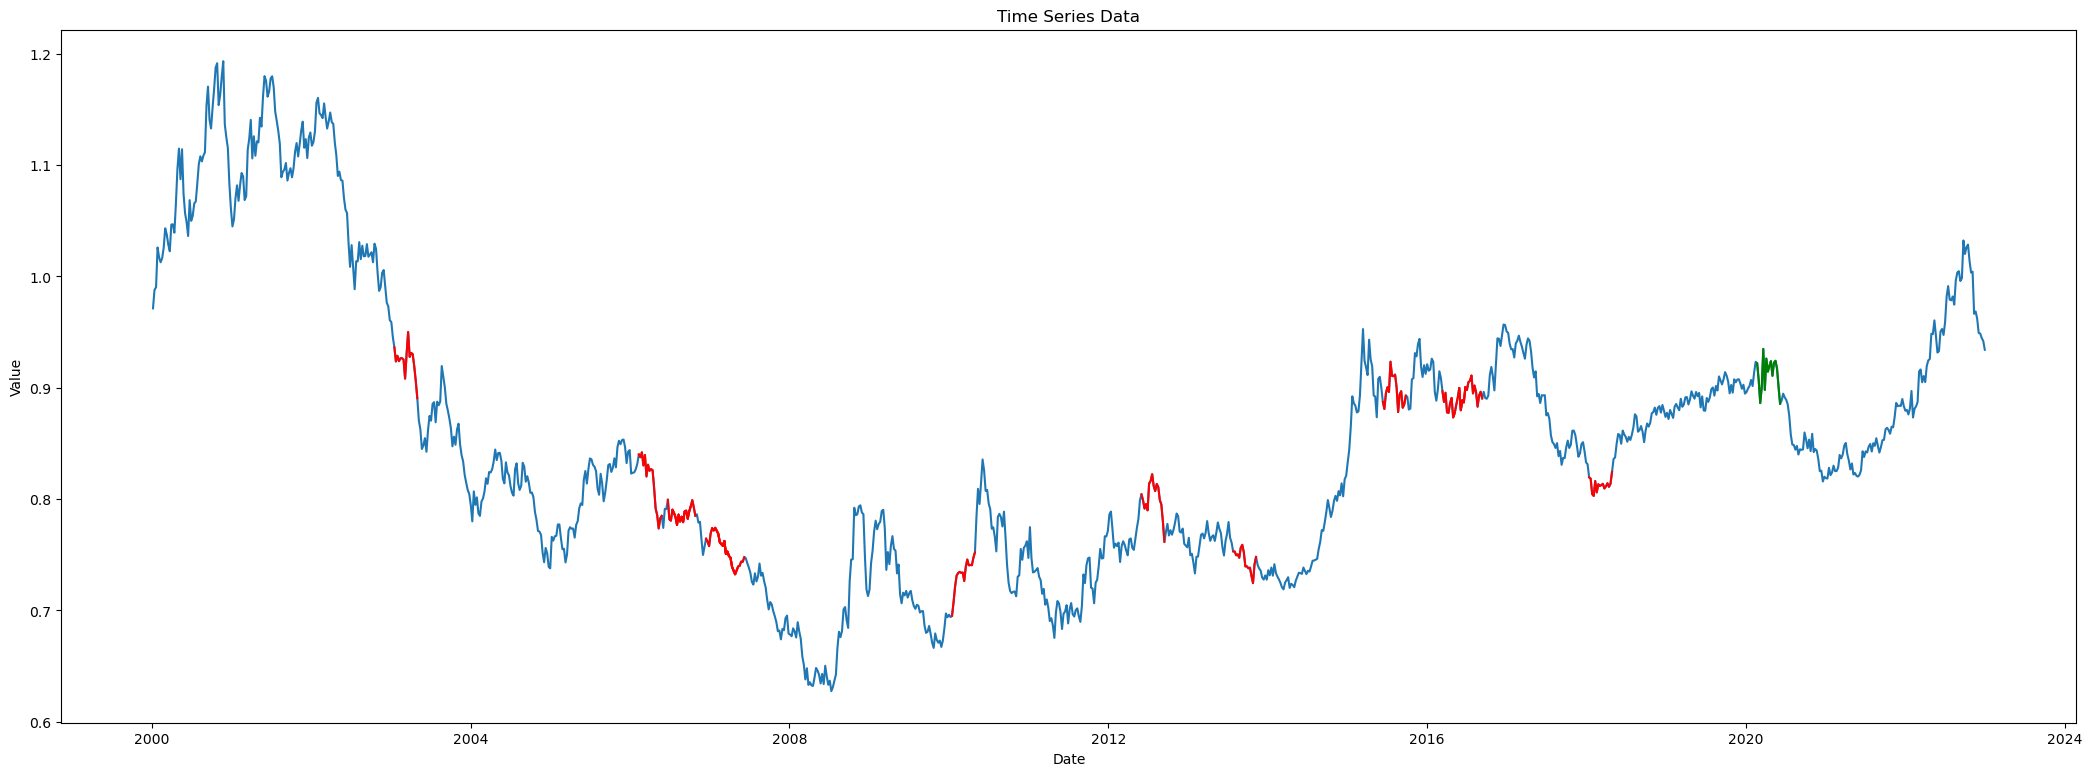

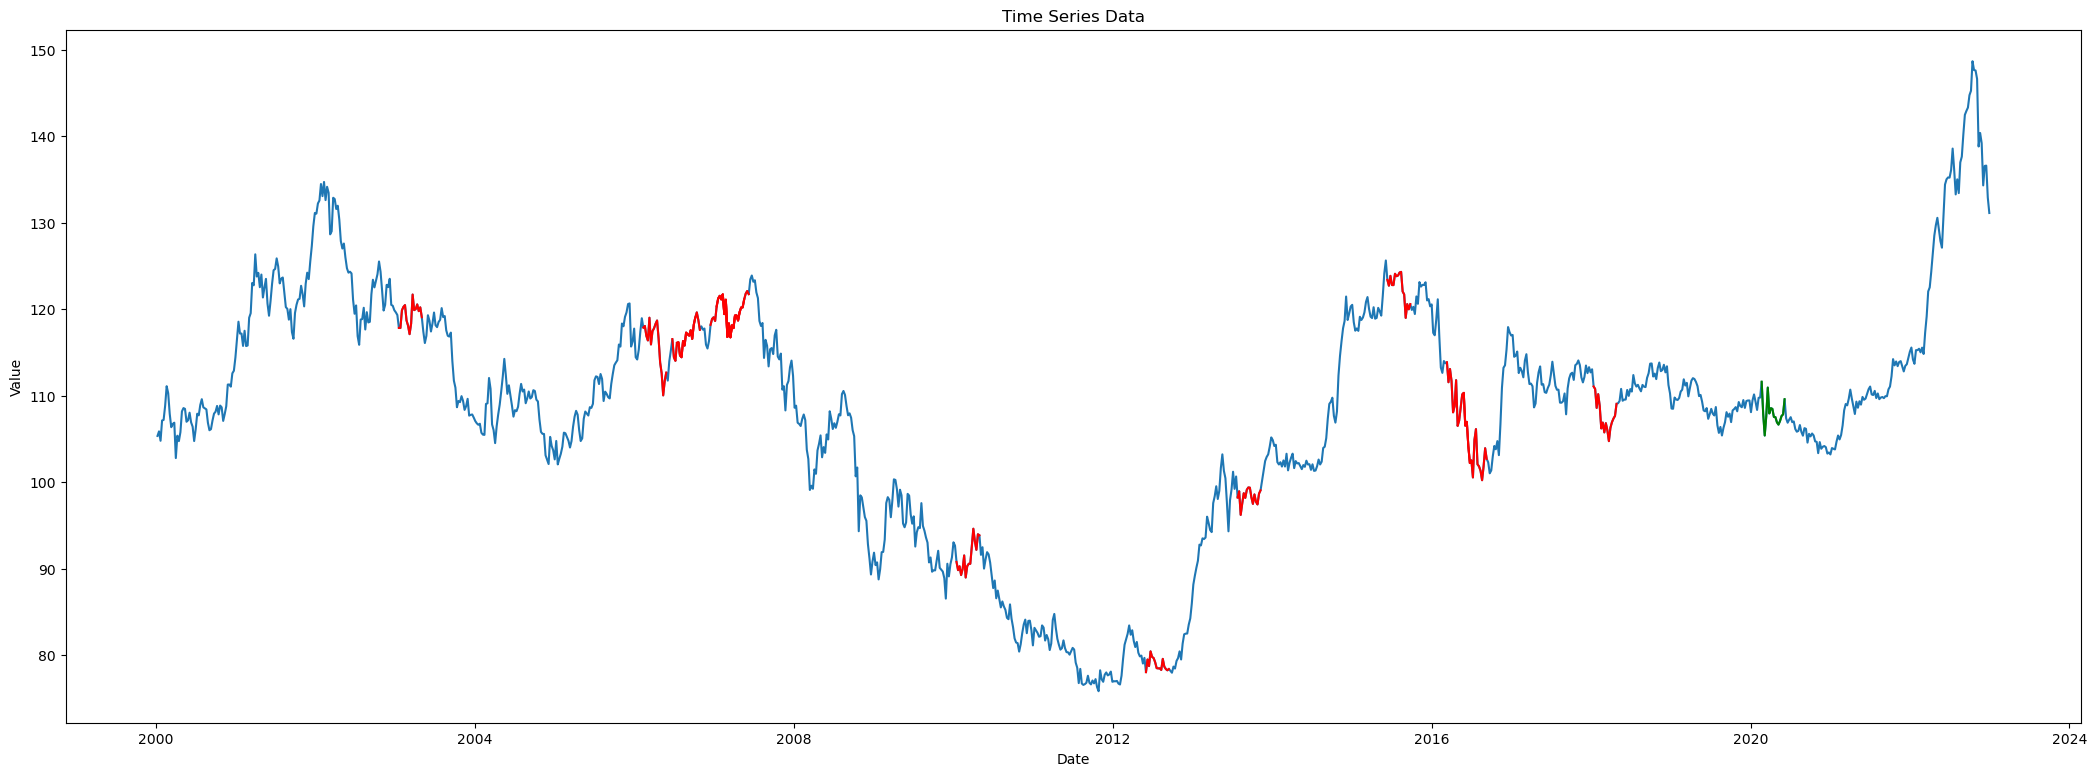

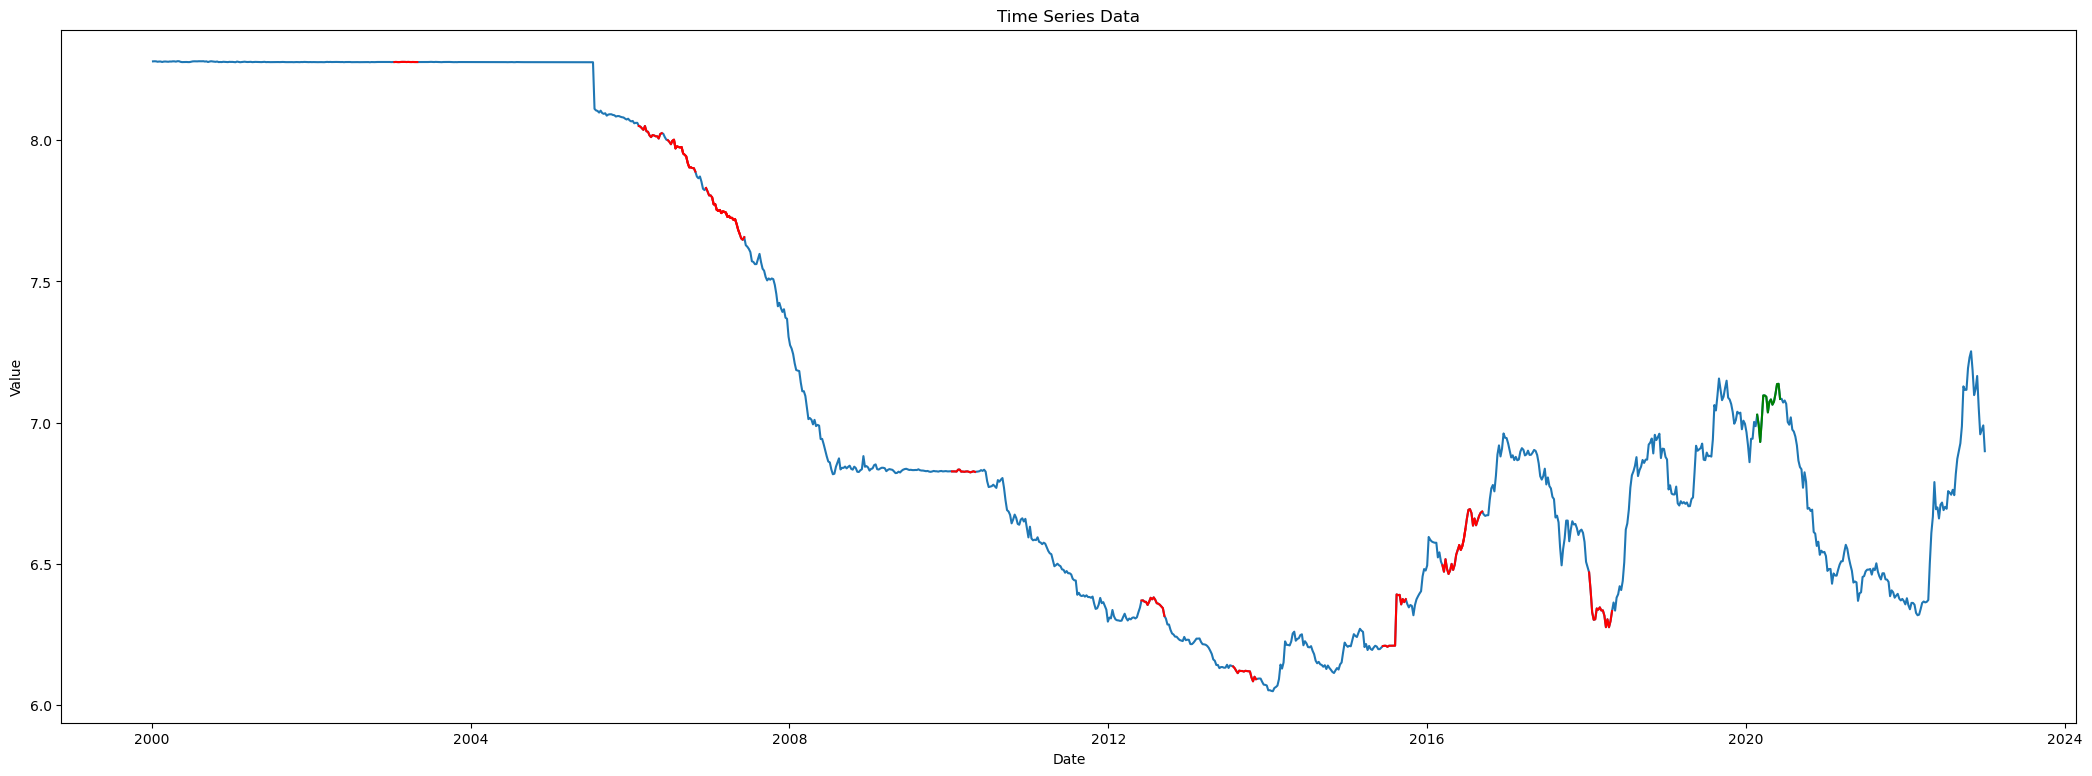

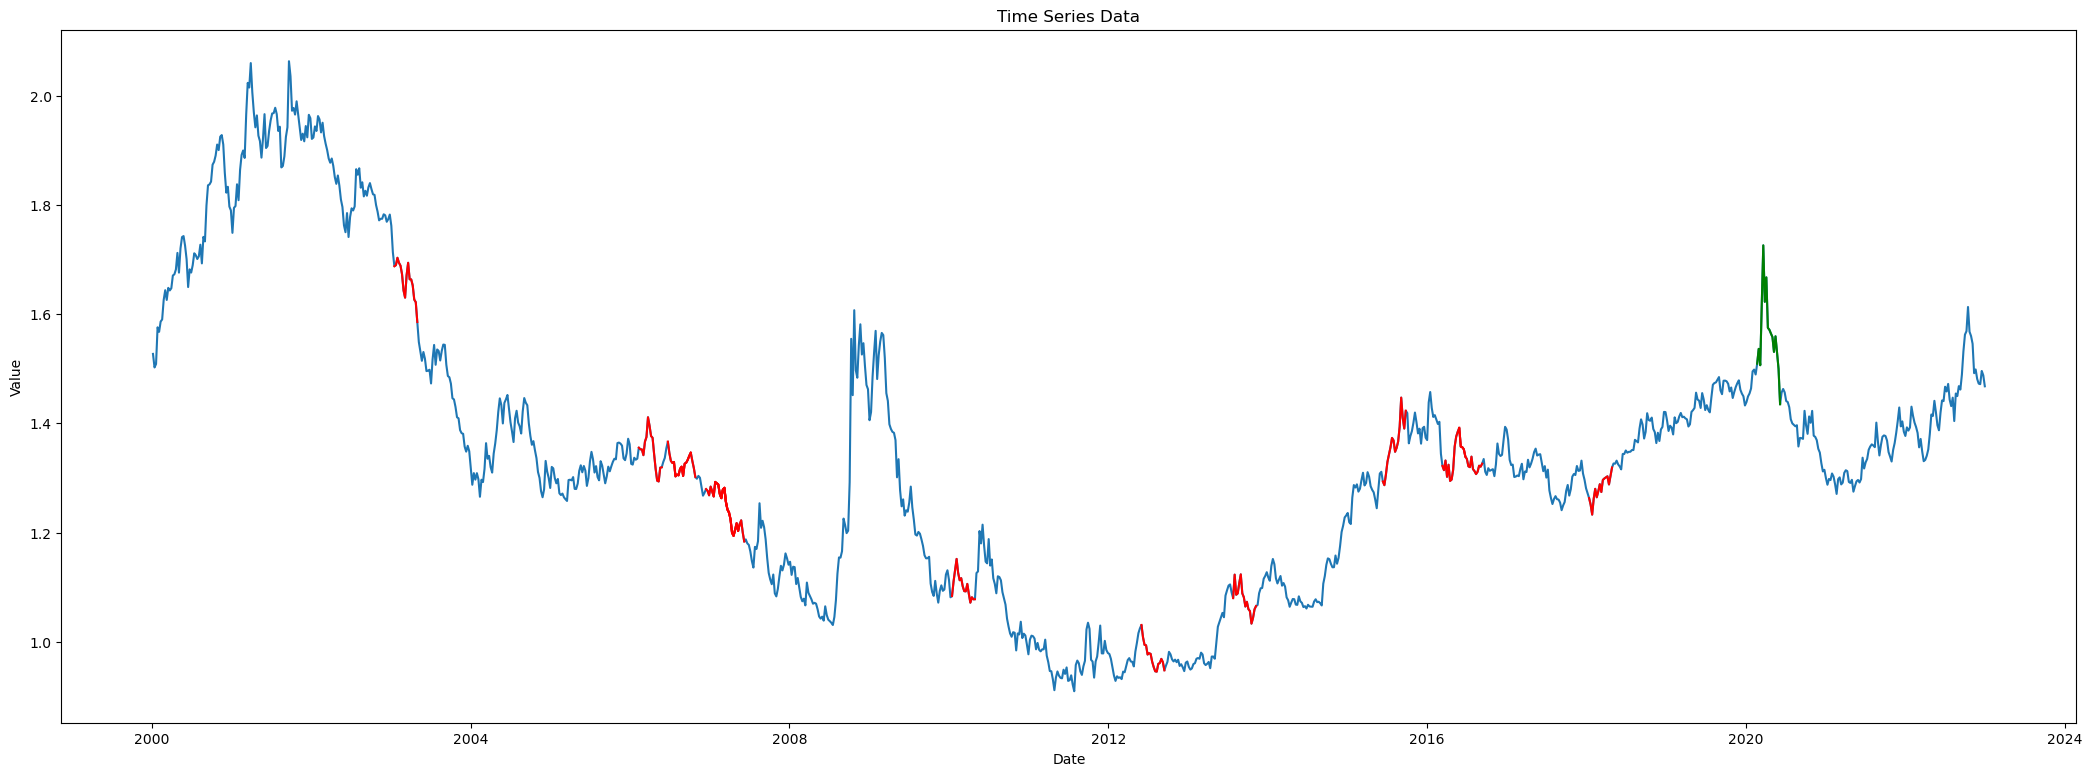

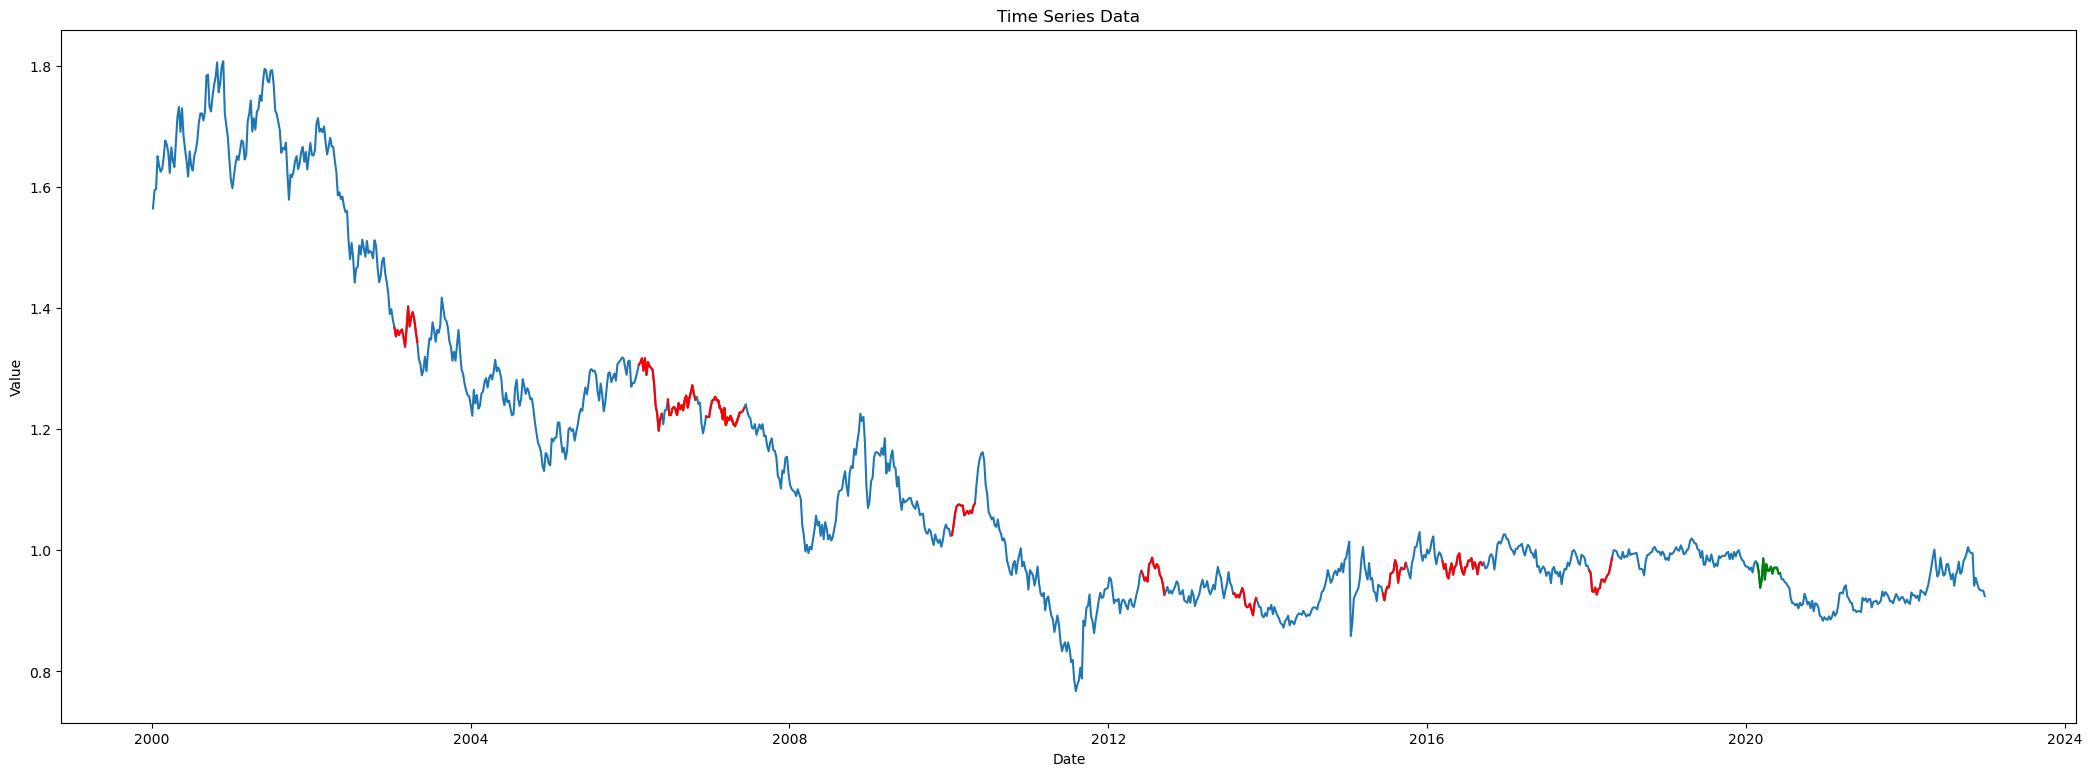

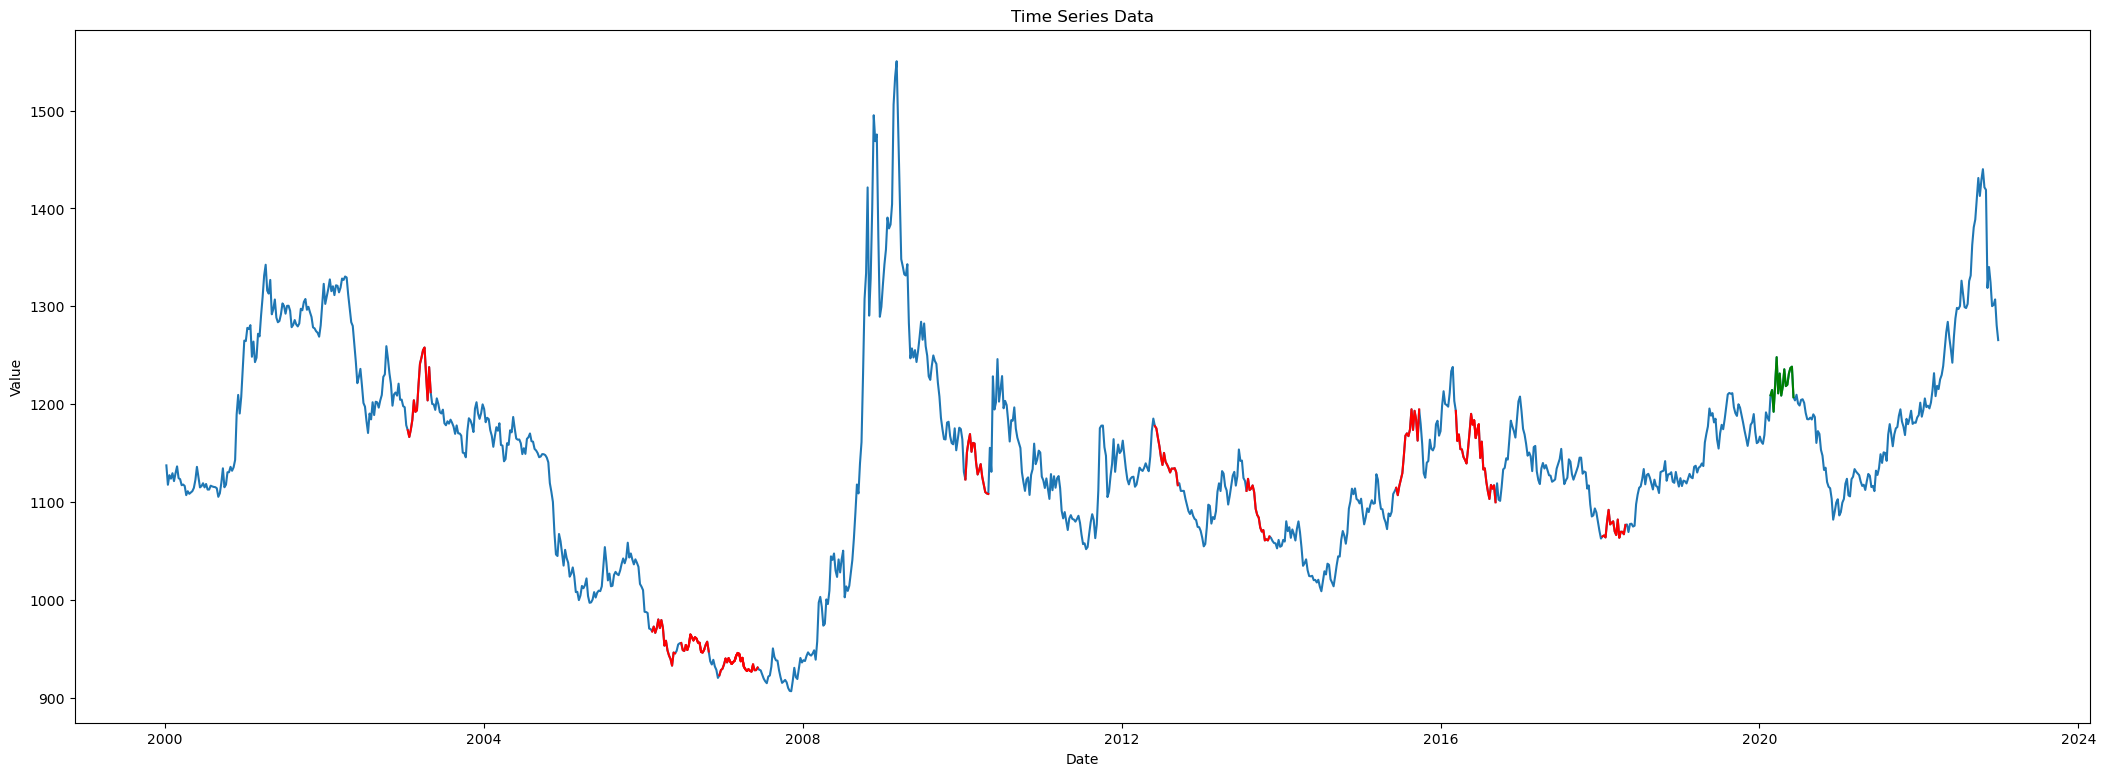

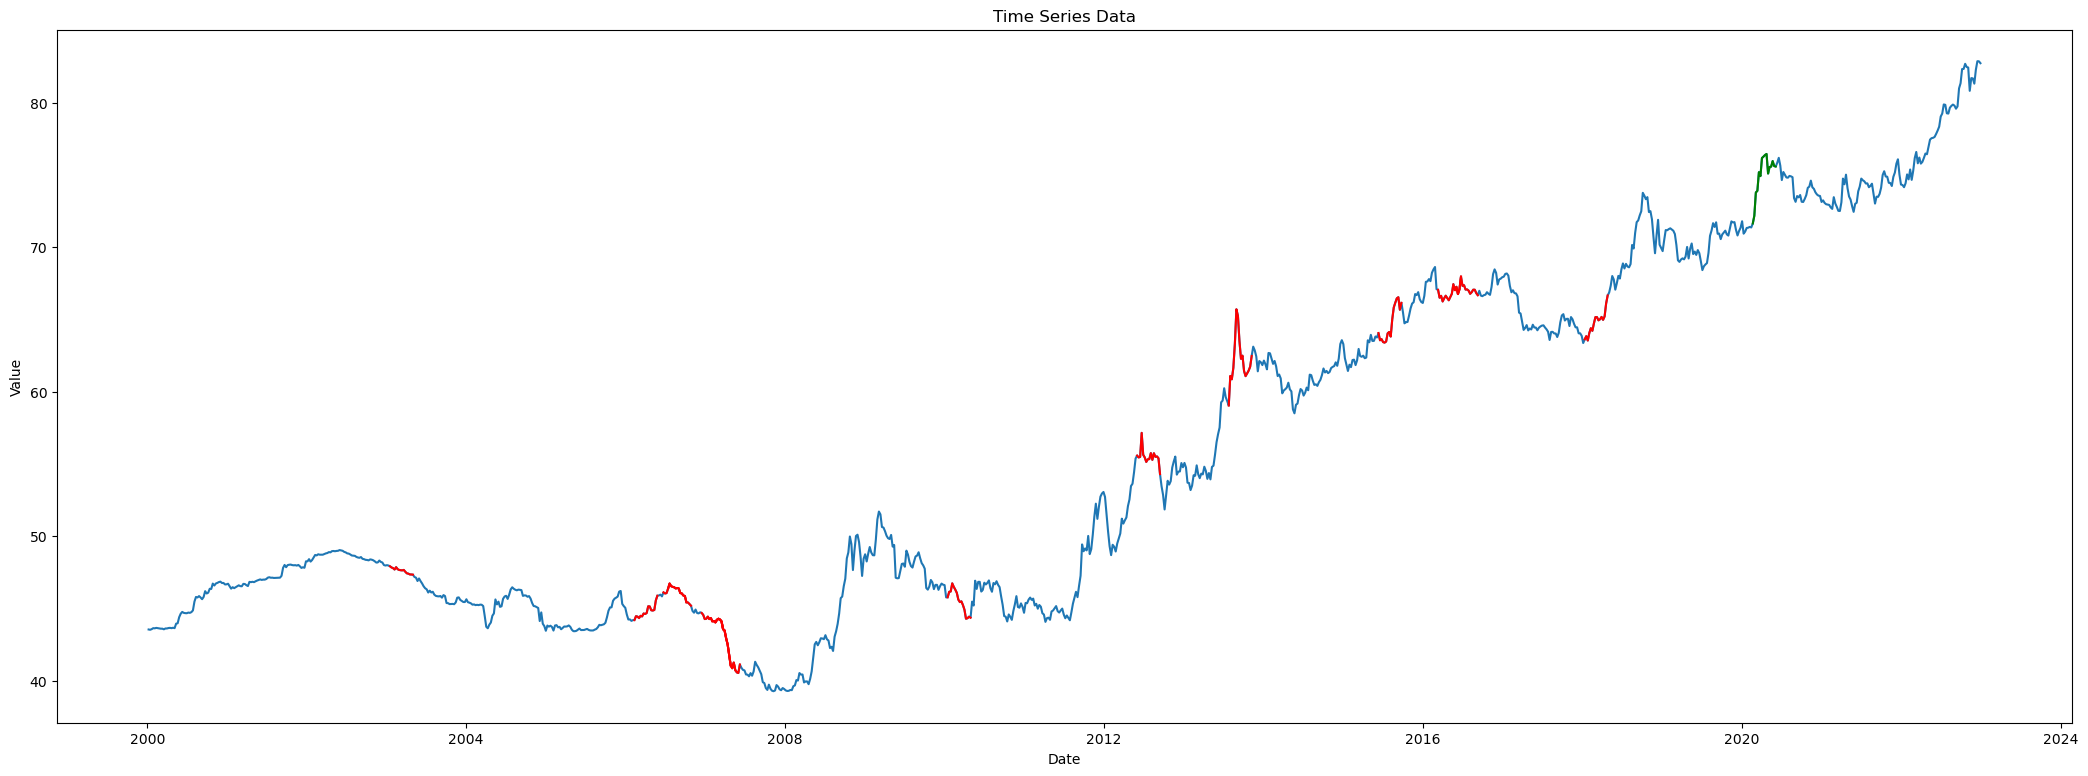

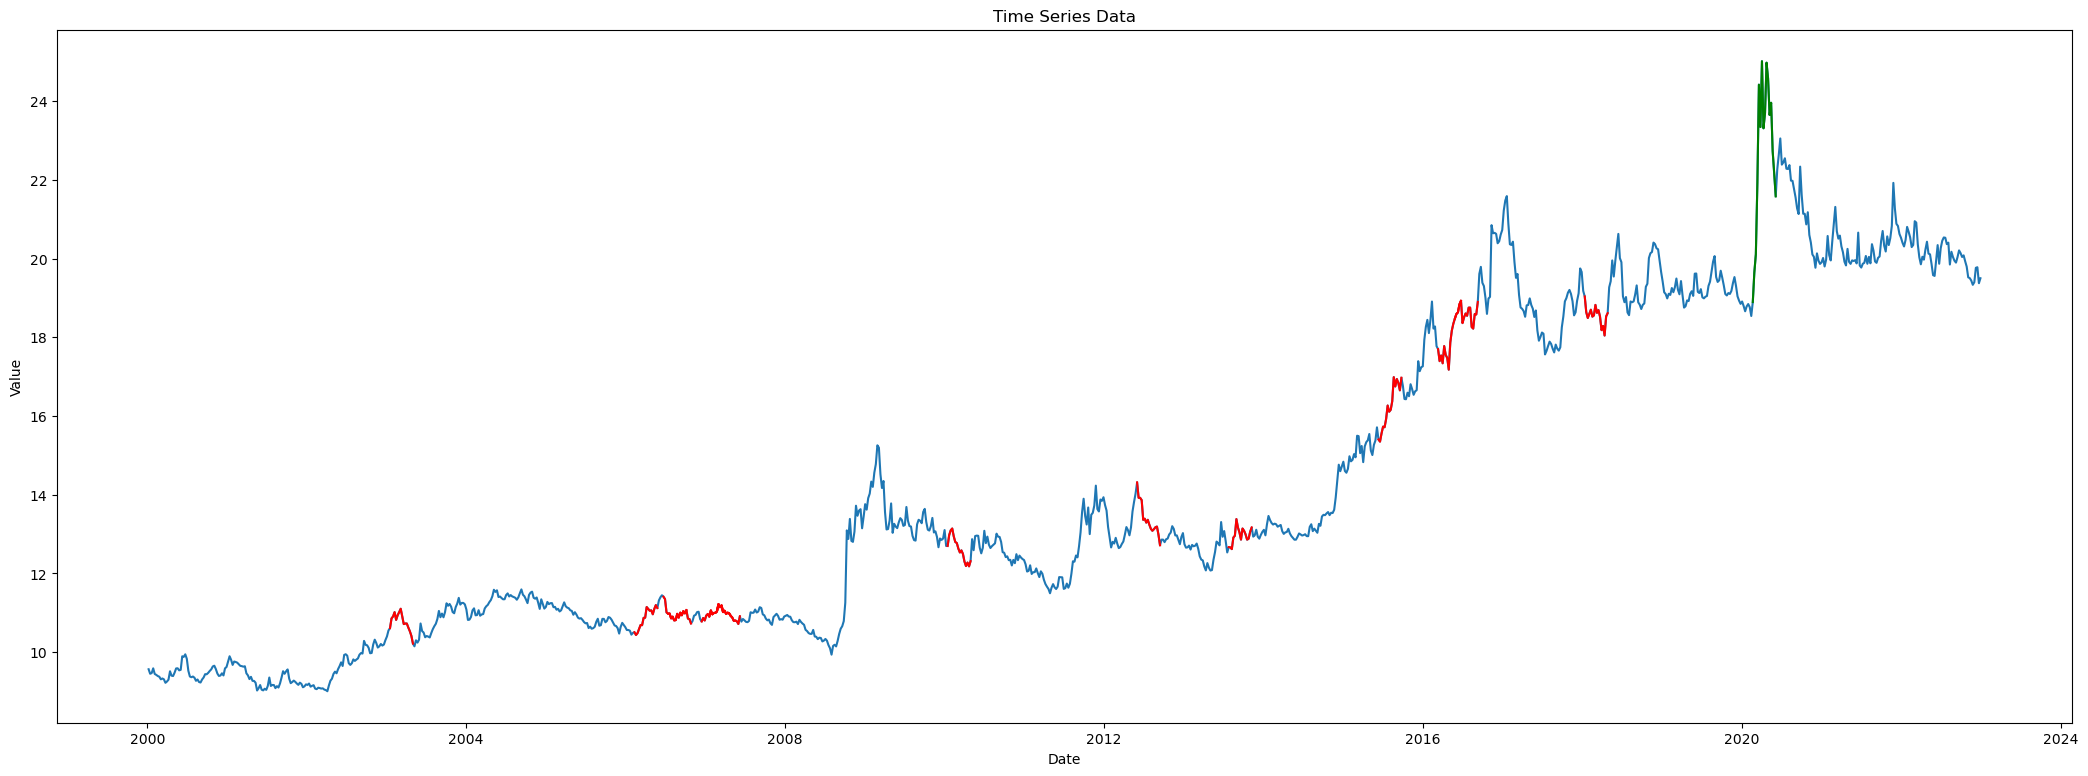

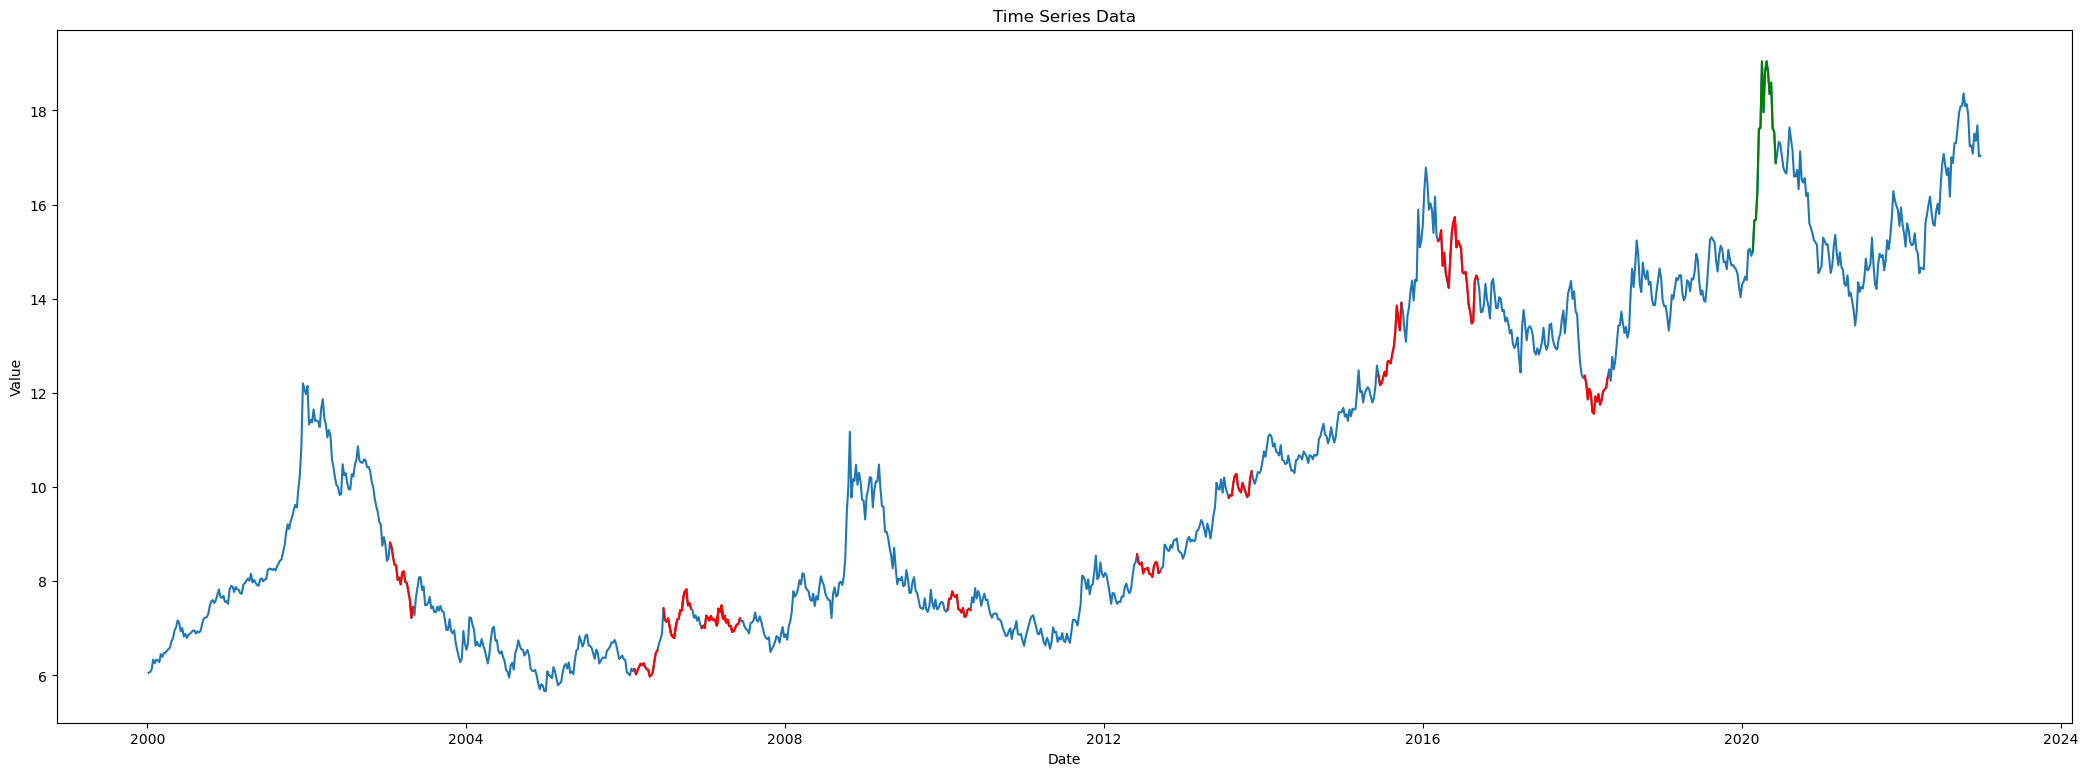

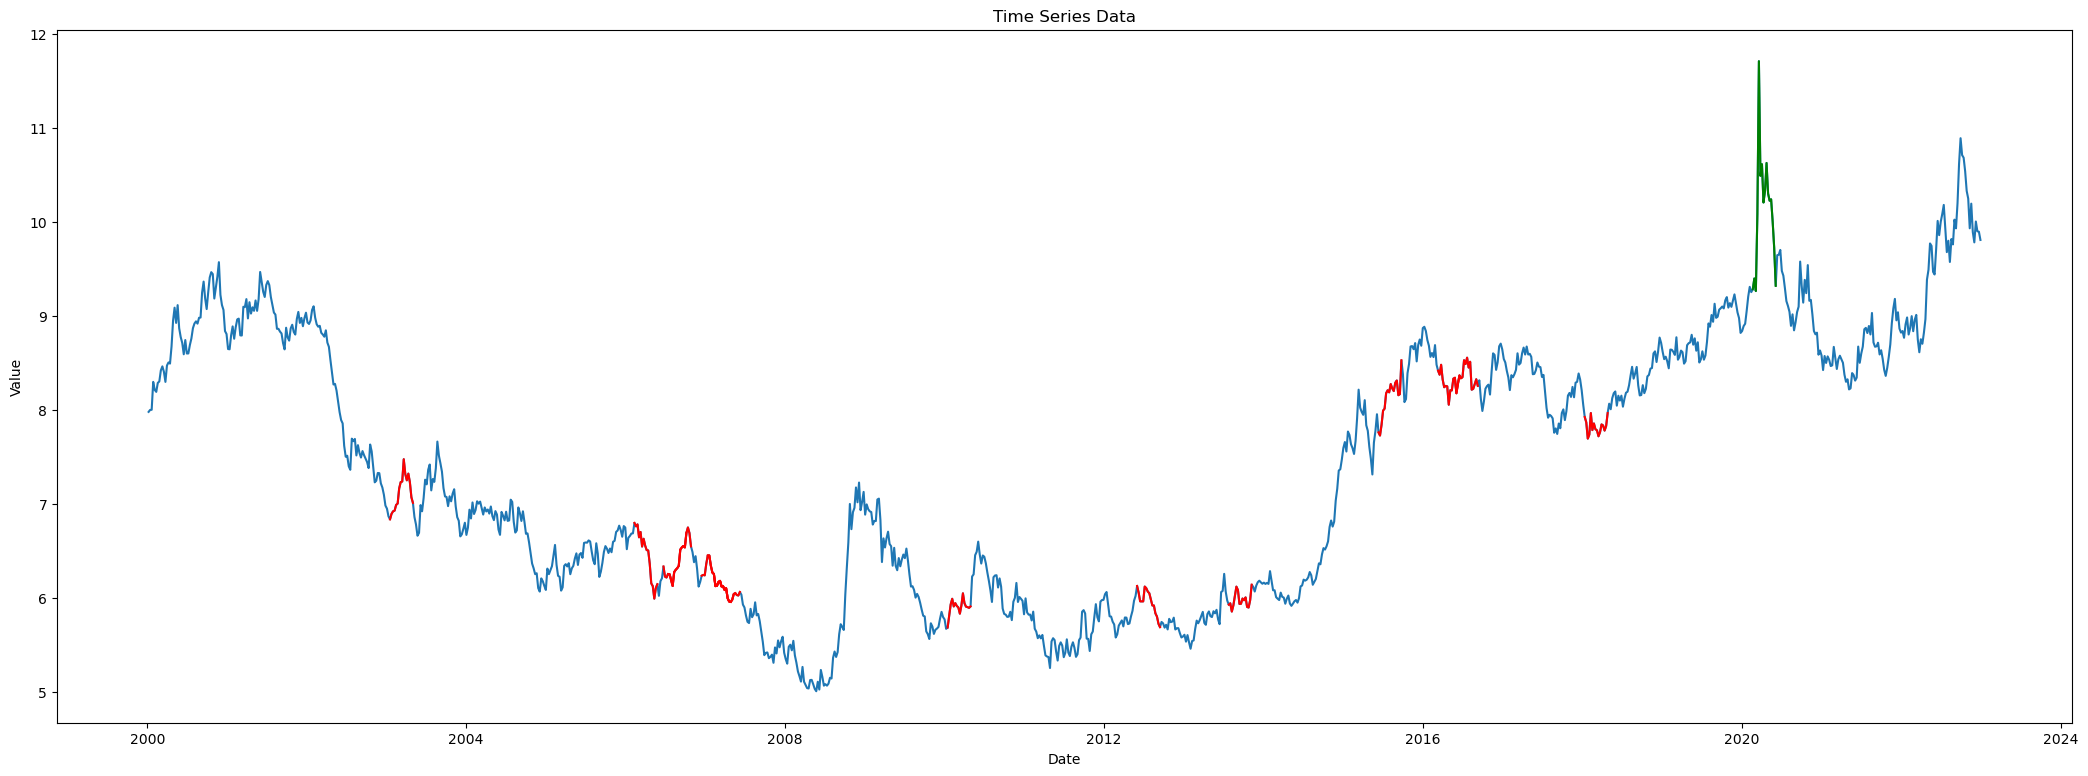

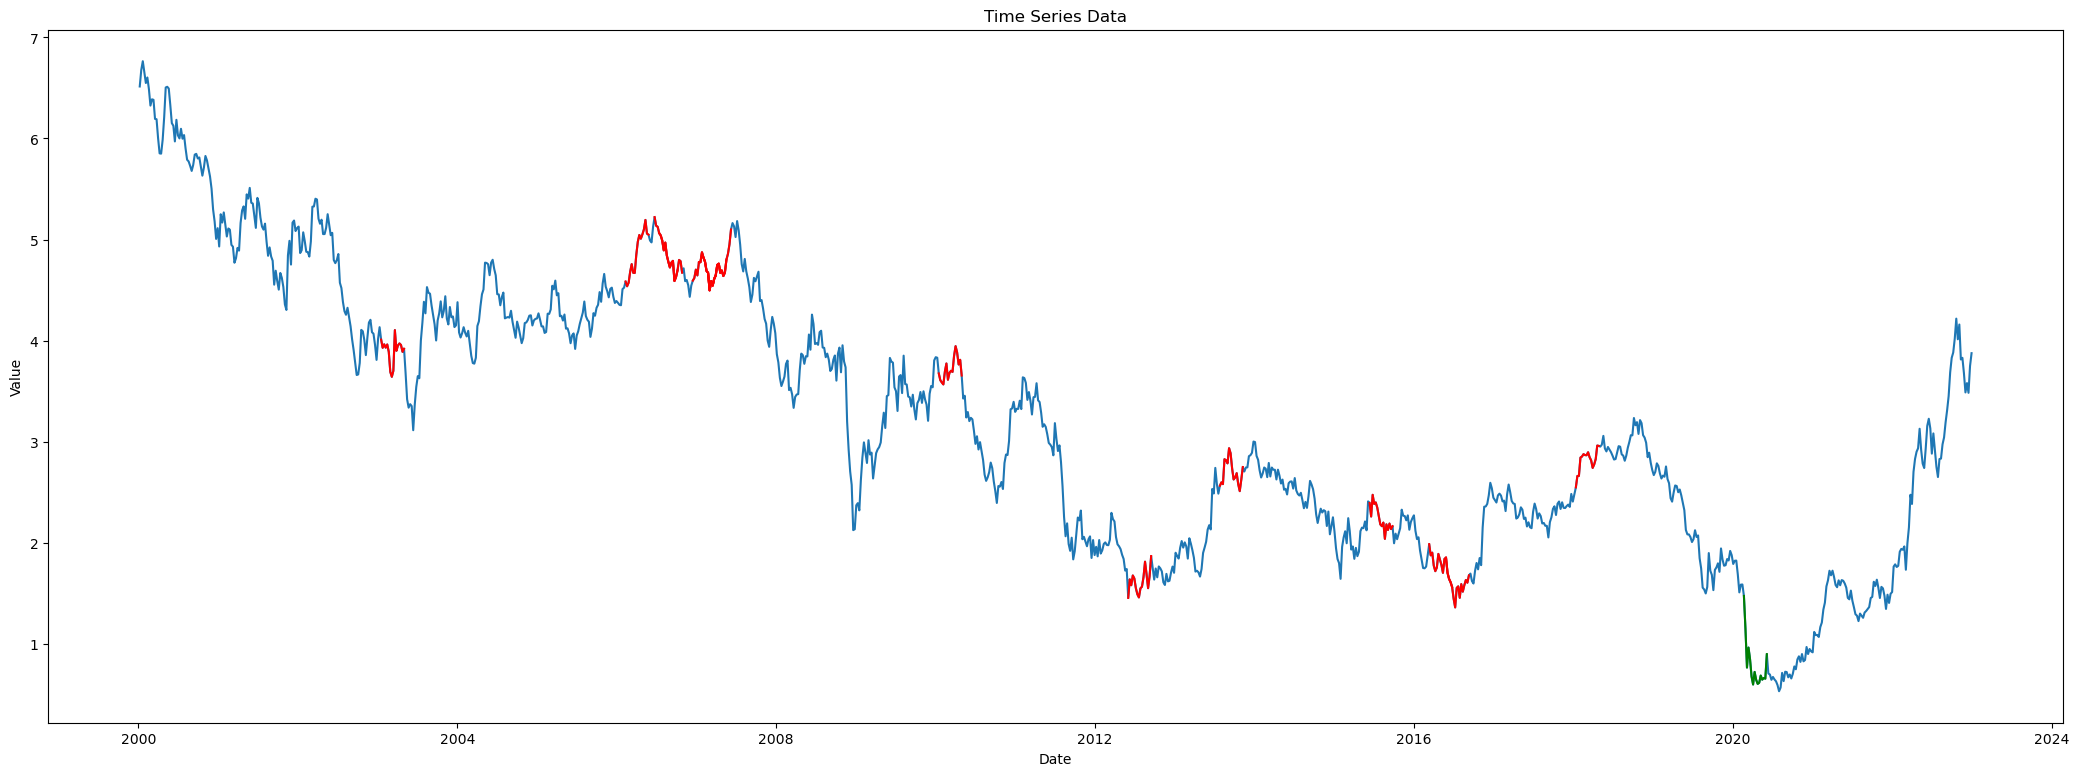

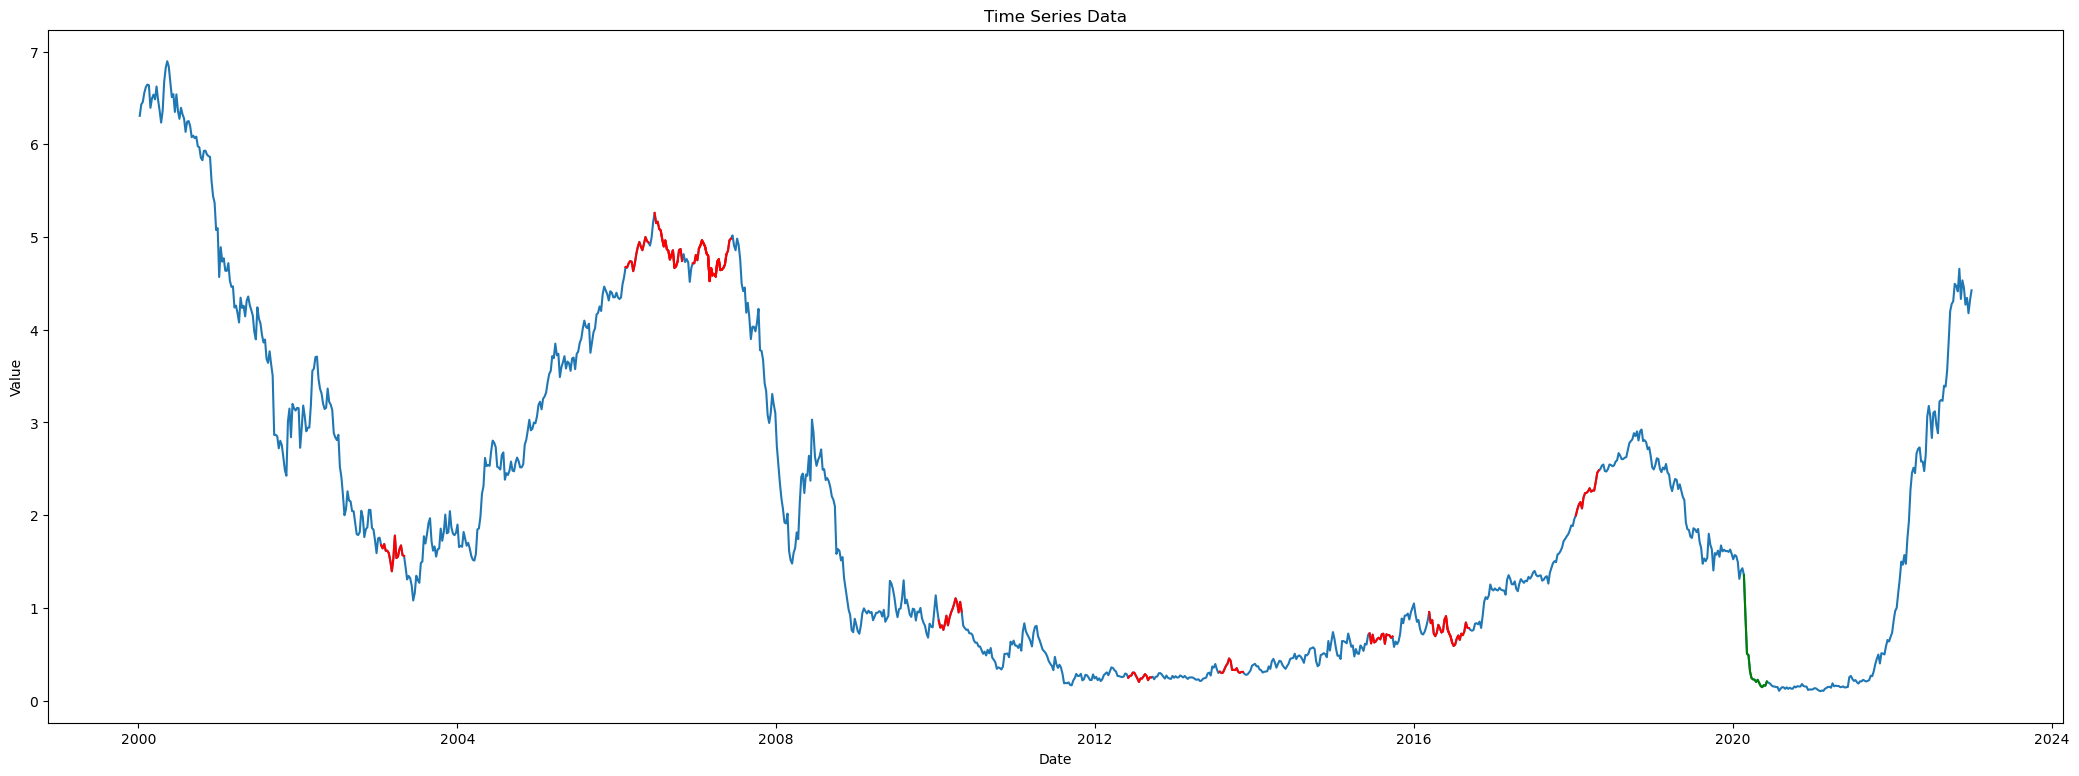

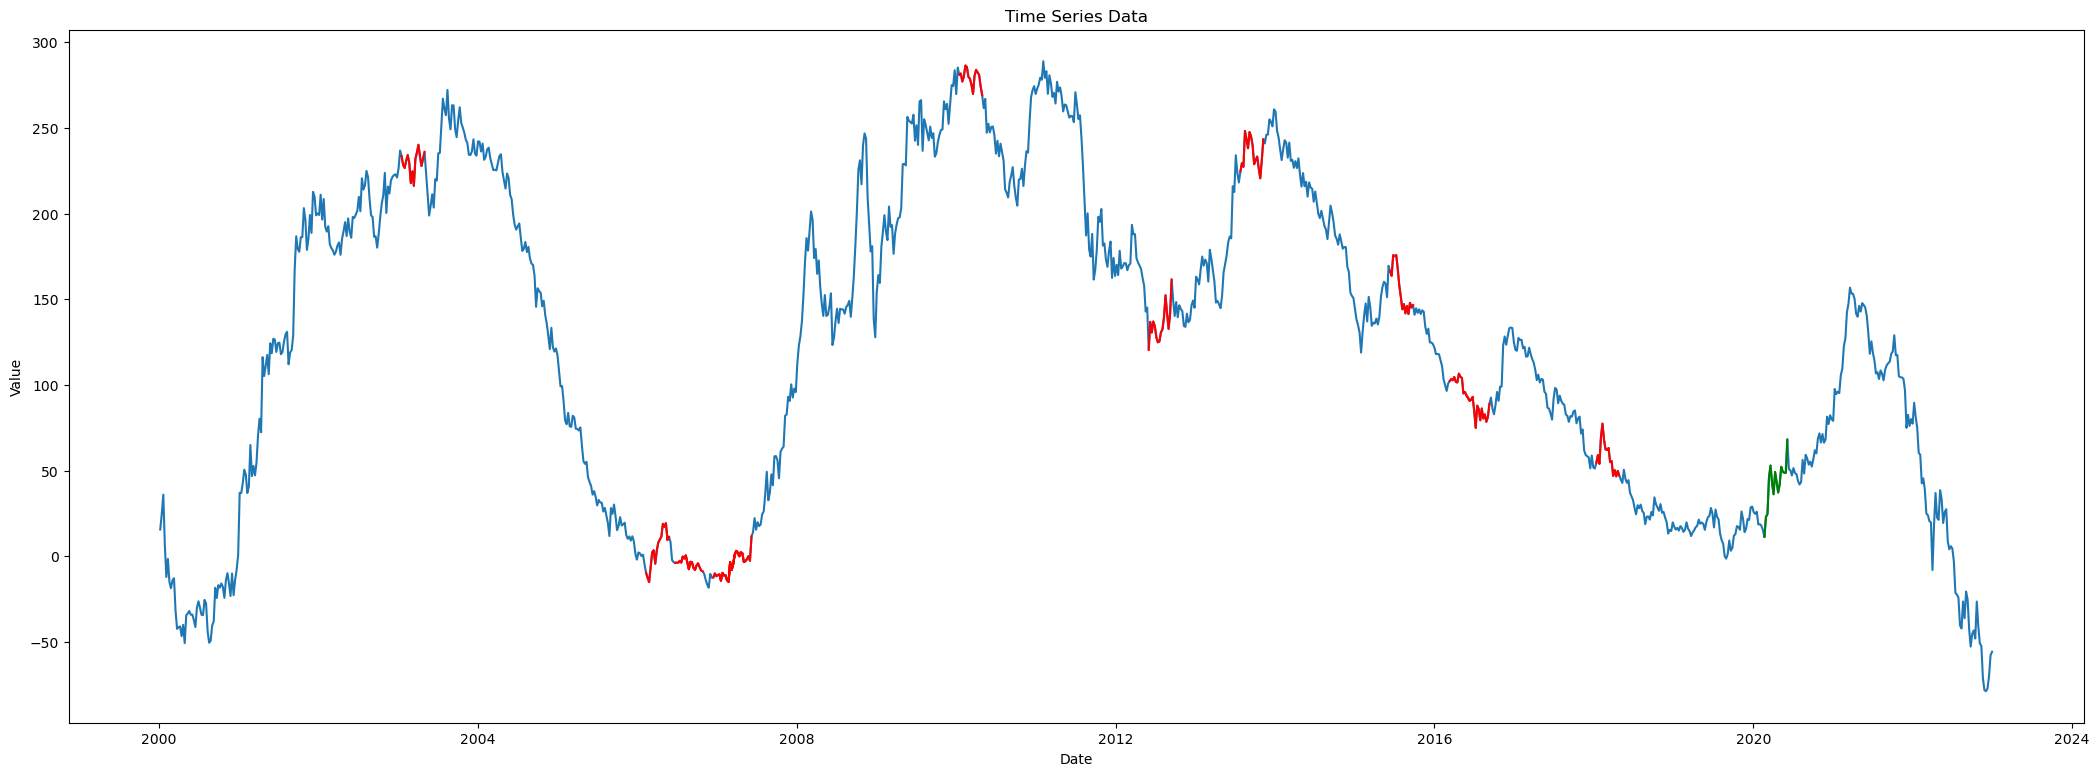

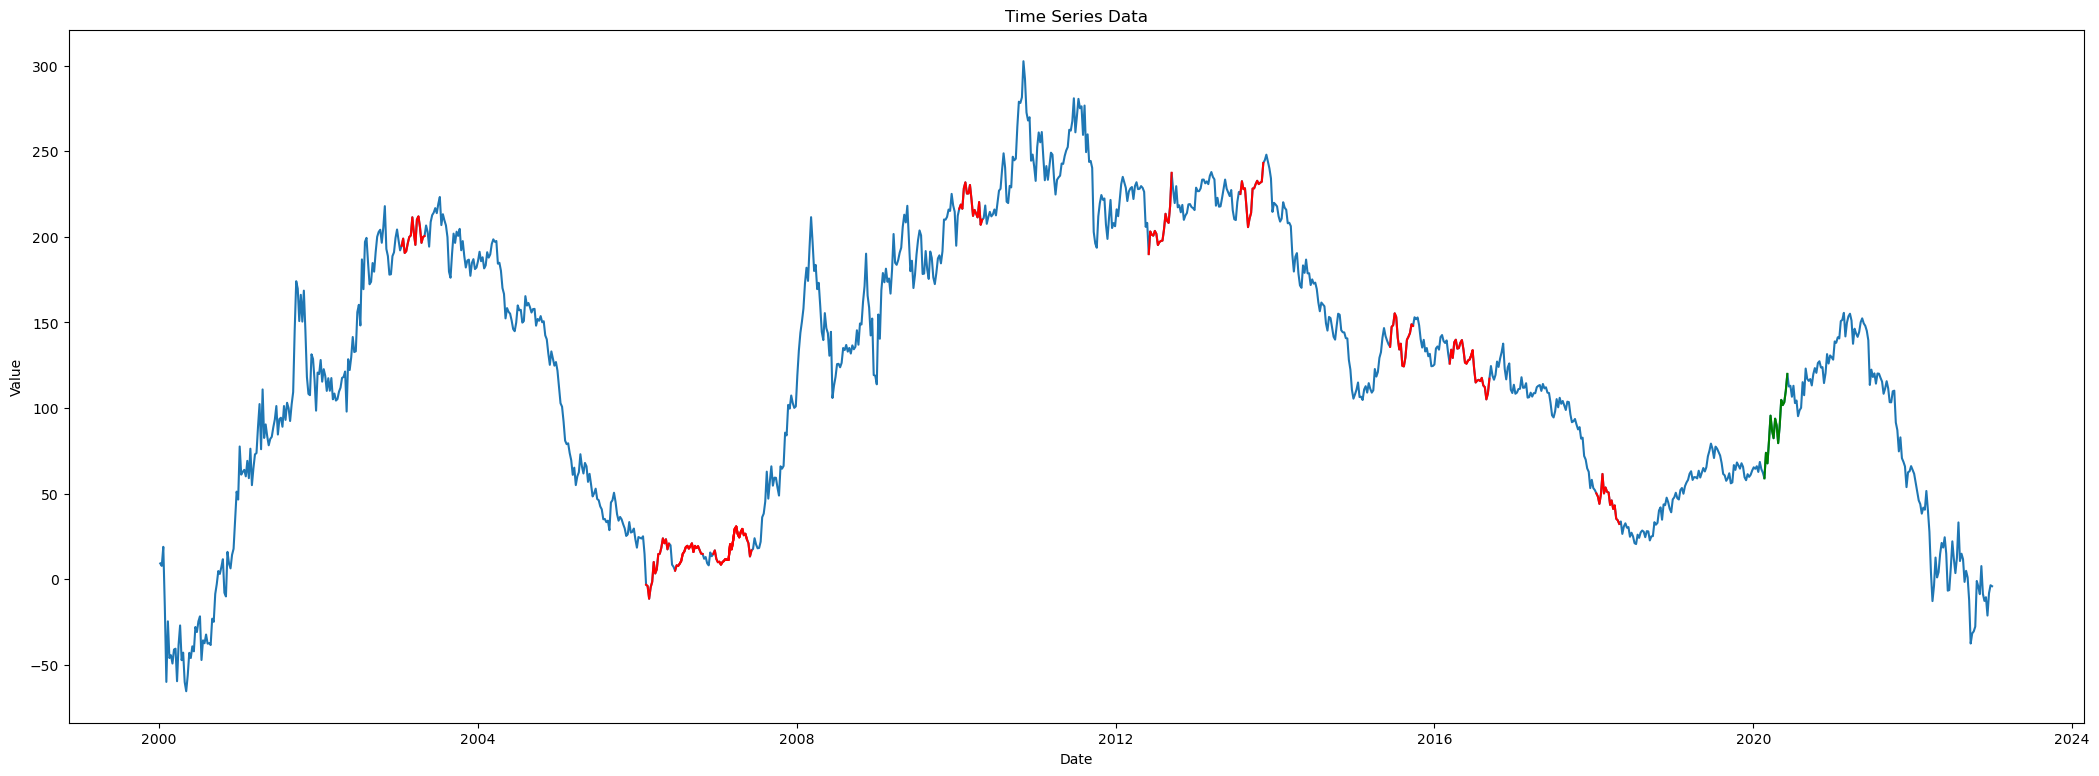

In [44]:
for i in range(len(asset_pchange_list)):
    target_index = 960+start_index
    plot(asset_price_list[i], date_list, asset_pchange_list[i], p_date_list, n_smallest_index, window, target_index)

In [ ]:
# start_index = 0
# window = 50
# n = 5
# i = 15

# p_asset = asset_pchange_list[i]
# asset = asset_price_list[i]

# p_tsdm = TSMD(p_asset)
# p_tsdm.search(p_asset[start_index:start_index+window], n)
# plot(asset, date_list, p_asset,p_date_list, p_tsdm.n_smallest_index, window)

# tsdm = TSMD(asset)
# tsdm.search(asset[start_index:start_index+window], n, False)
# plot(asset, date_list, p_asset,p_date_list, tsdm.n_smallest_index, window)